## Analysis of Seasonal Cycles and Initial Difference Maps

In [ ]:
import xarray as xr
import os
import numpy as np
import netCDF4 as nc
import pandas as pd
from scipy import stats 
from scipy.interpolate import griddata, RectBivariateSpline
import matplotlib.pyplot as plt 
import statistics
#import seaborn as sns
from tqdm.auto import tqdm 
import operator as op
import cartopy as cart
import matplotlib.ticker as mticker
#from mpl_toolkits.axes_grid1 import make_axes_locatable
import pyproj
#from mpl_toolkits.basemap import Basemap, interp
import matplotlib.colors as colors
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from scipy.stats import kstest, mannwhitneyu, ks_2samp
GeoAxes._pcolormesh_patched = Axes.pcolormesh
import matplotlib.dates as mdates
import cartopy
import cartopy.feature as cfeature

In [2]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

def get_closest_station(coordinates):
    
    nearest = min(stations_coordinates, key=lambda x: haversine(x[1], x[0], coordinates[1], coordinates[0]))
    return nearest

In [3]:
size = (15, 15)
longdis = 15
latdis = 15
resolution = '10m'

# Map generation Code
def generateMap(central_longitude=0):
    
    fig = plt.figure(figsize=size)
    ax = fig.add_subplot(111)
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=central_longitude))
    ax.coastlines()
    gl = ax.gridlines(ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.xlocator = mticker.FixedLocator((range(-180, 180, longdis)))
    gl.ylocator = mticker.FixedLocator((range(-90, 90, latdis)))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
    ax.add_feature(cart.feature.BORDERS)

In [4]:
# Anomaly claculation
def standardize(x):
    return (x - x.mean())/x.std()

## Data - ERA5 and NOAA CPC

In [5]:
%cd ERA5/precip_dailytotal
#first re-grid on 360x180 grid with 1x1 gridcells
yearly_precip_regridded = xr.open_dataset('precip_daily_total_1979-2019_regrid.nc', engine='netcdf4')
#yearly_precip_regridded

D:\RainHeatData\ERA5\precip_dailytotal


In [6]:
#convert ERA5 precipitation to mm
yearly_precip_regridded = yearly_precip_regridded.tp*1000

In [7]:
%cd ..
%cd ..
import csv
NINO = pd.read_csv('nino34.long.anom.data.csv')
NINO.head()

D:\RainHeatData\ERA5
D:\RainHeatData


,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1870,-1.00,-0.95,-0.83,-0.81,-1.27,-1.08,-1.04,-0.88,-0.53,-0.92,-0.79,-0.79
1,1871,-0.25,-0.58,-0.43,-0.50,-0.70,-0.53,-0.60,-0.33,-0.24,-0.33,-0.31,-0.58
2,1872,-0.72,-0.62,-0.50,-0.77,-0.62,-0.52,-0.32,-0.85,-1.02,-0.94,-0.79,-0.88
3,1873,-0.78,-1.01,-1.31,-0.67,-0.53,-0.48,-0.58,-0.39,-0.34,-0.78,-0.77,-0.70
4,1874,-0.93,-1.06,-1.40,-0.94,-0.86,-0.72,-1.00,-1.05,-1.13,-1.25,-1.33,-1.14


In [8]:
NINO_DJF = NINO[['Year','Dec','Jan','Feb']].copy()
NINO_DJF

,Year,Dec,Jan,Feb
0,1870,-0.79,-1.00,-0.95
1,1871,-0.58,-0.25,-0.58
2,1872,-0.88,-0.72,-0.62
3,1873,-0.70,-0.78,-1.01
4,1874,-1.14,-0.93,-1.06
...,...,...,...,...
148,2018,0.97,-0.86,-0.73
149,2019,0.51,0.51,0.62
150,2020,-0.98,0.64,0.48
151,2021,-1.07,-1.04,-0.94


In [9]:
NINO_DJF = NINO_DJF.set_index('Year')
#NINO_DJF.head()

<AxesSubplot:xlabel='Year'>

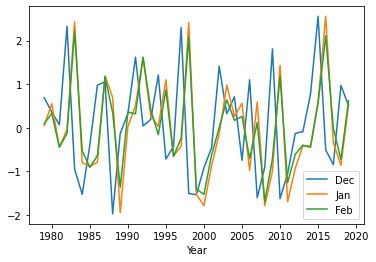

In [10]:
NINO_DJF.loc['1979':'2019'].plot()

In [11]:
%cd ERA5
%cd humid_heat\regridded_daymeans

D:\RainHeatData\ERA5
D:\RainHeatData\ERA5\humid_heat\regridded_daymeans


In [12]:
all_tw_regridded = xr.open_dataset('TW_daily_max_1979-2020_daymean_regridded.nc', engine='netcdf4')
#all_tw_regridded

In [13]:
%cd ..
%cd ..
%cd ..
daily_precip_regrid = xr.open_dataset('NOAA_CPC/precip_daily_total_1979-2022_regrid.nc', engine='netcdf4')
daily_precip_regrid

D:\RainHeatData\ERA5\humid_heat
D:\RainHeatData\ERA5
D:\RainHeatData


<xarray.Dataset>
Dimensions:  (time: 15748, lon: 360, lat: 180)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2022-02-11
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Data variables:
    precip   (time, lat, lon) float32 ...
Attributes:
    CDI:            Climate Data Interface version 1.9.9rc1 (https://mpimet.m...
    Conventions:    CF-1.0
    history:        Sun Feb 13 09:24:11 2022: cdo remapbil,grid_info.txt prec...
    version:        V1.0
    title:          CPC GLOBAL PRCP V1.0
    dataset_title:  CPC GLOBAL PRCP V1.0
    References:     https://www.psl.noaa.gov/data/gridded/data.cpc.globalprec...
    CDO:            Climate Data Operators version 1.9.9rc1 (https://mpimet.m...

In [14]:
#%cd RainHeatData
%cd ERA5/2mtemp_dailymean/processed

D:\RainHeatData\ERA5\2mtemp_dailymean\processed


In [15]:
#2mtemp_dailymax from ERA5
temp_dailymean = xr.open_dataset('2mtemp_dailymean_1979-2019_regridded.nc', engine='netcdf4')
temp_dailymean

<xarray.Dataset>
Dimensions:  (time: 14975, lon: 360, lat: 180)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-12-31
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Data variables:
    t2m      (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.9rc1 (https://mpimet.mpg...
    Conventions:  CF-1.6
    history:      Tue Mar 01 13:11:48 2022: cdo remapbil,grid_info_2.txt 2mte...
    CDO:          Climate Data Operators version 1.9.9rc1 (https://mpimet.mpg...

In [16]:
### diff between NOAA and ERA5 precip ###

#yearly_precip_regridded_JJA = yearly_precip_regridded.where(yearly_precip_regridded.time.dt.month.isin([6,7,8]),drop=True)
#daily_precip_regrid_JJA = daily_precip_regrid.precip.where(daily_precip_regrid.precip.time.dt.month.isin([6,7,8]),drop=True)

In [13]:
precip_difference = np.zeros((yearly_precip_regridded_JJA.shape[1], yearly_precip_regridded_JJA.shape[2]))

for i in range(yearly_precip_regridded_JJA.shape[1]):
    
    for j in range(yearly_precip_regridded_JJA.shape[2]):
        
        ERA5_precip = yearly_precip_regridded_JJA[:,i,j]
        NOAA_precip = daily_precip_regrid_JJA[:,i,j]
        
        precip_difference[i][j] = ERA5_precip.mean('time') - NOAA_precip.mean('time')
#negative difference: NOAA precip has higher values than ERA5
#positive difference: ERA5 has higher values than NOAA

In [30]:
diff = yearly_precip_regridded_JJA - daily_precip_regrid_JJA
diff

<xarray.DataArray (time: 3772, lat: 180, lon: 360)>
array([[[0.15576929, 0.15576929, 0.15449151, ..., 0.15576929,
         0.15576929, 0.15576929],
        [0.09704009, 0.09704009, 0.09704009, ..., 0.10215119,
         0.10087341, 0.09704009],
        [0.07925978, 0.06865995, 0.06081954, ..., 0.07915869,
         0.08171052, 0.08426607],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[0.3447123 , 0.3434345 , 0.34216046, ..., 0.3447123 ,
         0.3447123 , 0.3447123 ],
        [0.14810264, 0.14555454, 0.14427677, ..., 0.15703216,
         0.14938042, 0.14938042],
        [0.0102222 , 0.00766665, 0.00766665, ..., 0.01277775,
         0.01149997, 0.0102222 ],
...
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[0.36793202, 0.36793202, 0.36674365, ..., 0.36793202,
         0.36793202, 0.36793202],
        [0.2821982 , 0.28338656, 0.28339028, ..., 0.28816238,
         0.2857782 , 0.28458238],
        [0.16551465, 0.16908348, 0.17027557, ..., 0.1690872 ,
         0.16789511, 0.16313046],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1979-06-01 1979-06-02 ... 2019-08-31
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5

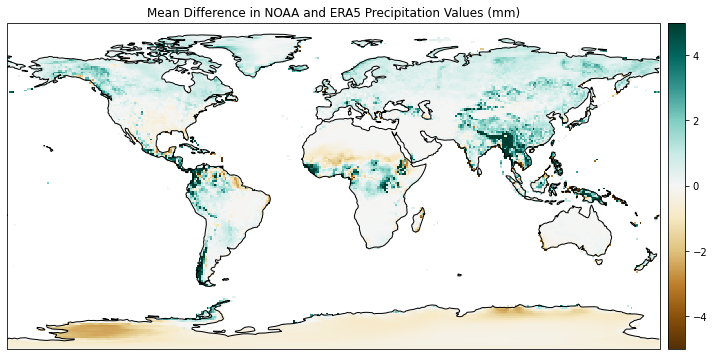

In [32]:
lats = np.argwhere((yearly_precip_regridded.lat.values >= -90) & (yearly_precip_regridded.lat.values <= 90))
lons = np.argwhere((yearly_precip_regridded.lon.values >= 0) & (yearly_precip_regridded.lon.values <= 360))

precip_data = yearly_precip_regridded.sel(lon = slice(0,360), lat=slice(-90,90))
TW_data = all_tw_regridded.sel(lon = slice(0,360), lat=slice(0,90))

fig= plt.figure(figsize=(12,6))
ax = plt.axes(projection=ccrs.PlateCarree())
cm = plt.cm.get_cmap('BrBG')
res = '110m'
ax.add_feature(cfeature.COASTLINE.with_scale(res))
#gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
 #                 linewidth=1, color='gray', alpha=0.5, linestyle='--', zorder=10)
sc = plt.pcolormesh(yearly_precip_regridded.lon.values[lons[:,0]], yearly_precip_regridded.lat.values[lats[:,0]], diff.mean('time'),transform=ccrs.PlateCarree(), cmap='BrBG') #coolwarm, BrBG
#plt.pcolormesh(yearly_precip_regridded.lon.values[US_lons[:,0]], yearly_precip_regridded.lat.values[US_lats[:,0]], np.ma.masked_less(significant_mask, 0), facecolor = 'None', edgecolors = None)
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
ax.set_title('Mean Difference in NOAA and ERA5 Precipitation Values (mm)')
#Difference in Mean Wet Bulb Temperature Anomaly 1 day before Extreme Precipitation Anomaly Days
#Difference in Mean Extreme Precipitation Anomaly 2 days before Extreme Wet Bulb Temperature Anomaly Days
plt.colorbar(sc, cax=cax) # Similar to fig.colorbar(im, cax = cax)
plt.clim(-5, 5)
#plt.savefig('/RainHeatData/median_temp_diff_USA_signficant.png')
plt.show()

## US Anomalies

#### ERA5 Precipitation Climatology and Anomalies

In [18]:
#ERA5 data: US lats 20-60, US long 230-300
US_lats = np.argwhere((yearly_precip_regridded.lat.values >= 20) & (yearly_precip_regridded.lat.values <= 60))
US_lons = np.argwhere((yearly_precip_regridded.lon.values >= 230) & (yearly_precip_regridded.lon.values <= 300))

In [19]:
US_precip_data = yearly_precip_regridded.sel(lon = slice(230,300), lat=slice(20,60)) #select US coords
US_precip_data = US_precip_data.where(US_precip_data.time.dt.month.isin([6,7,8]),drop=True) #JJA months

US_TW_data = all_tw_regridded.sel(lon = slice(230,300), lat=slice(20,60))
US_TW_data = US_TW_data.where(US_TW_data.time.dt.month.isin([6,7,8]),drop=True) #JJA months

In [14]:
# Calculate the anomaly for 5 day rolling mean
#rolling = US_precip_data.tp.rolling(time=5, center=True).mean('time')
#rolling_mean = US_precip_data.tp.groupby('time.dayofyear') - rolling

In [20]:
# cut precip data so time matches TW data
US_TW_data = US_TW_data.sel(time = slice('1979-01-01T00:00:00.000000000','2019-12-21T00:00:00.000000000'))

In [23]:
#ERA5 precip daily average
US_precip_mean = US_precip_data.groupby('time.dayofyear').mean(dim='time')

#5 day rolling mean- ERA5 precip
US_precip_rolling = US_precip_data.rolling(time=5, center=True).mean('time') 

In [25]:
#ERA5 precipitation anomaly - removes seasonality
US_precip_data_anom_smooth = US_precip_data.groupby('time.dayofyear') - US_precip_rolling.groupby('time.dayofyear').mean(dim='time')
US_precip_data_anom = US_precip_data.groupby('time.dayofyear') - US_precip_mean

#US_precip_data.tp.groupby('time.dayofyear').mean(dim='time')

In [34]:
#precip_anom__mean = US_precip_data.mean(dim=('lon','lat'))
#precip_rolling_1D = precip_anom__mean.rolling(time=5, center=True).mean('time')
#precip_rolling = US_precip_data.rolling(time = 5, center = True).mean('time')


### Seasonal cycles -- focus on SW USA

In [50]:
#Phoenix, AZ Seasonal Cycles

#ERA5
phoen_era = yearly_precip_regridded.sel(lat='33.5', lon='292.5')
phoen_era_monthly = phoen_era.groupby('time.month').mean(dim='time')
#NOAA
phoen_noaa = daily_precip_regrid.precip.sel(lat='33.5', lon='292.5')
phoen_noaa_monthly = phoen_noaa.groupby('time.month').mean(dim='time')
#TW
phoen_TW = all_tw_regridded.TW.sel(lat='33.5', lon='292.5')
phoen_TW_monthly = phoen_TW.groupby('time.month').mean(dim='time')
#t2m
phoen_t2m = temp_dailymean.t2m.sel(lat='33.5', lon='292.5')
phoen_t2m_monthly = phoen_t2m.groupby('time.month').mean(dim='time')

In [51]:
#phoen_t2m_monthly.plot()

#anomaly = (phoen_era.groupby('time.month')-phoen_era_monthly)
#anomaly.plot()

#ERA5 precip daily average
#US_precip_mean = US_precip_data.groupby('time.dayofyear').mean(dim='time')
#5 day rolling mean- ERA5 precip
#US_precip_rolling = US_precip_mean.tp.rolling(time=5, center=True).mean('time') 
#US_precip_rolling.sel(lat='33.5', lon='292.5').plot()

phoen_era = yearly_precip_regridded.sel(lat='33.5', lon='292.5')
phoen_era_monthly = phoen_era.groupby('time.dayofyear').mean(dim='time')

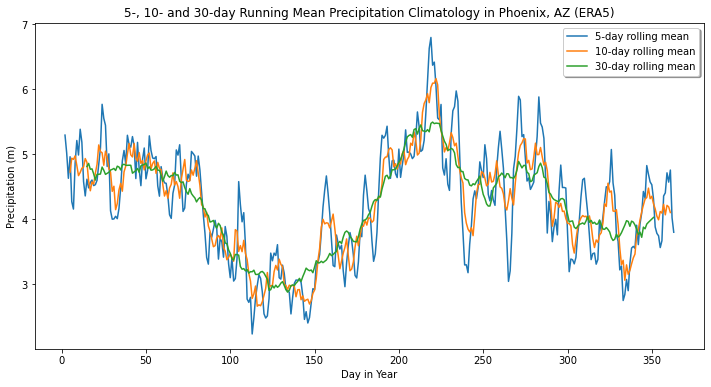

In [52]:
numbers_series = pd.Series(phoen_era_monthly)

#5 day rolling mean
rolling = numbers_series.rolling(5, center=True)
moving_averages = rolling.mean()

#10 day rolling mean
rolling_10= numbers_series.rolling(10, center=True)
moving_average_10 = rolling_10.mean()

#30 day rolling mean
rolling_30= numbers_series.rolling(30, center=True)
moving_average_30 = rolling_30.mean()

#moving_averages_list = moving_averages.tolist()
moving_averages.plot(figsize=(12,6))
moving_average_10.plot(figsize=(12,6))
moving_average_30.plot(figsize=(12,6))
plt.title("5-, 10- and 30-day Running Mean Precipitation Climatology in Phoenix, AZ (ERA5)")
plt.xlabel("Day in Year")
plt.ylabel("Precipitation (m)")
plt.legend(("5-day rolling mean","10-day rolling mean","30-day rolling mean"), shadow=True, fancybox=True)
#plt.savefig('/RainHeatData/Figures/rollingmeans_Phoenix.png')

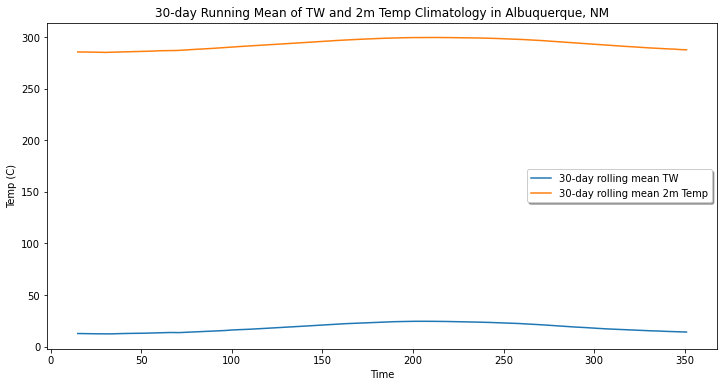

In [12]:
#wet bulb temperature
alb_TW = all_tw_regridded.TW.sel(lat='35.5', lon='285.5')
alb_TW_daily = alb_TW.groupby('time.dayofyear').mean(dim='time')
alb_TW_anom = alb_TW.groupby('time.dayofyear') - alb_TW_daily

#2m dry bulb temperature
alb_t = temp_dailymean.t2m.sel(lat='35.5', lon='285.5')
alb_t_daily = alb_t.groupby('time.dayofyear').mean(dim='time')
alb_t_anom = alb_t.groupby('time.dayofyear') - alb_t_daily

numbers_series = pd.Series(alb_TW_daily)
numbers_series2 = pd.Series(alb_t_daily)
#5 day rolling mean
rolling = numbers_series.rolling(5, center=True)
moving_averages = rolling.mean()
#rolling2 = numbers_series2.rolling(5, center=True)
#moving_averages2 = rolling2.mean()
#10 day rolling mean
rolling_10= numbers_series.rolling(10, center=True)
moving_average_10 = rolling_10.mean()
#rolling_10_2= numbers_series2.rolling(10, center=True)
#moving_average_10_2 = rolling_10_2.mean()
#30 day rolling mean
rolling_30= numbers_series.rolling(30, center=True)
moving_average_30 = rolling_30.mean()
rolling_30_2= numbers_series2.rolling(30, center=True)
moving_average_30_2 = rolling_30_2.mean()

#moving_averages_list = moving_averages.tolist()
#moving_averages.plot(figsize=(12,6))
#moving_average_10.plot(figsize=(12,6))
moving_average_30.plot(figsize=(12,6))
moving_average_30_2.plot(figsize=(12,6))
plt.title("30-day Running Mean of TW and 2m Temp Climatology in Albuquerque, NM")
plt.xlabel("Time")
plt.ylabel("Temp (C)")
plt.legend(("30-day rolling mean TW","30-day rolling mean 2m Temp"), shadow=True, fancybox=True)

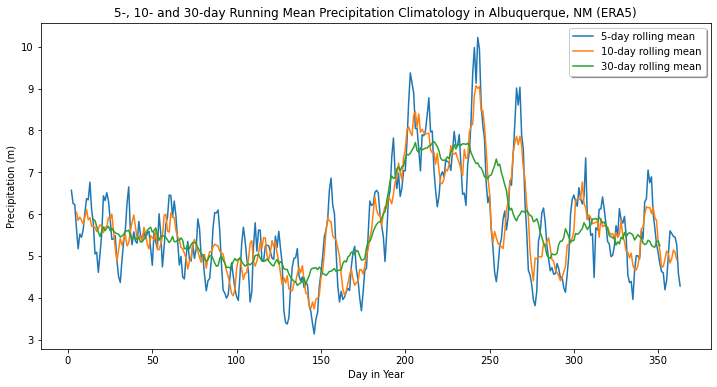

In [55]:
#5 day rolling mean
alb_era = yearly_precip_regridded.sel(lat='35.5', lon='285.5')
alb_era_monthly = alb_era.groupby('time.dayofyear').mean(dim='time')
alb_era_anom = alb_era.groupby('time.dayofyear') - alb_era_monthly

numbers_series = pd.Series(alb_era_monthly)

#5 day rolling mean
rolling = numbers_series.rolling(5, center=True)
moving_averages = rolling.mean()

#10 day rolling mean
rolling_10= numbers_series.rolling(10, center=True)
moving_average_10 = rolling_10.mean()

#30 day rolling mean
rolling_30= numbers_series.rolling(30, center=True)
moving_average_30 = rolling_30.mean()

#moving_averages_list = moving_averages.tolist()
moving_averages.plot(figsize=(12,6))
moving_average_10.plot(figsize=(12,6))
moving_average_30.plot(figsize=(12,6))
plt.title("5-, 10- and 30-day Running Mean Precipitation Climatology in Albuquerque, NM (ERA5)")
plt.xlabel("Day in Year")
plt.ylabel("Precipitation (m)")
plt.legend(("5-day rolling mean","10-day rolling mean","30-day rolling mean"), shadow=True, fancybox=True)
#plt.savefig('/RainHeatData/Figures/rollingmeans_Albuquerque.png')
#alb_era_roll = alb_era.groupby('time.dayofyear').rolling(5, center=True).mean(dim='time')

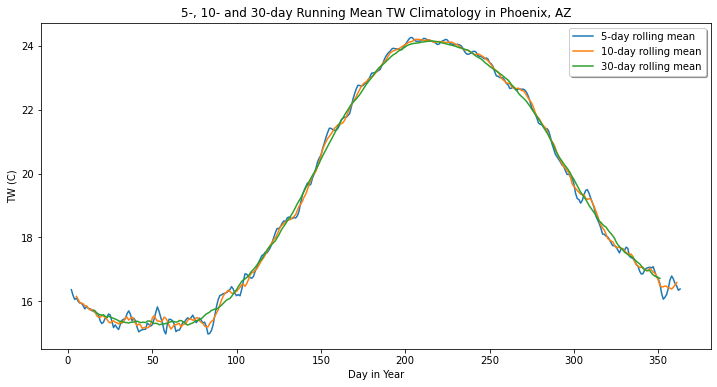

In [56]:
phoen_TW = all_tw_regridded.TW.sel(lat='33.5', lon='292.5')
phoen_TW_daily = phoen_TW.groupby('time.dayofyear').mean(dim='time')
phoen_TW_anom = phoen_TW.groupby('time.dayofyear') - phoen_TW_daily

numbers_series = pd.Series(phoen_TW_daily)
#5 day rolling mean
rolling = numbers_series.rolling(5, center=True)
moving_averages = rolling.mean()
#10 day rolling mean
rolling_10= numbers_series.rolling(10, center=True)
moving_average_10 = rolling_10.mean()
#30 day rolling mean
rolling_30= numbers_series.rolling(30, center=True)
moving_average_30 = rolling_30.mean()

#moving_averages_list = moving_averages.tolist()
moving_averages.plot(figsize=(12,6))
moving_average_10.plot(figsize=(12,6))
moving_average_30.plot(figsize=(12,6))
plt.title("5-, 10- and 30-day Running Mean TW Climatology in Phoenix, AZ")
plt.xlabel("Day in Year")
plt.ylabel("TW (C)")
plt.legend(("5-day rolling mean","10-day rolling mean","30-day rolling mean"), shadow=True, fancybox=True)
#plt.savefig('/RainHeatData/Figures/rollingmeans_TW_Phoenix.png')


In [58]:
#Albuquerque, NM Seasonal Cycles

#ERA5
alb_era = yearly_precip_regridded.tp.sel(lat='35.5', lon='285.5')
alb_era_monthly = alb_era.groupby('time.month').mean(dim='time')
#NOAA
alb_noaa = daily_precip_regrid.precip.sel(lat='35.5', lon='285.5')
#TW
alb_TW = all_tw_regridded.TW.sel(lat='35.5', lon='285.5')
#t2m
alb_t2m = temp_dailymean.t2m.sel(lat='35.5', lon='285.5')

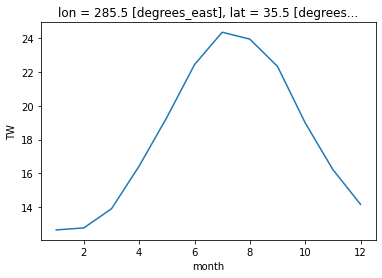

In [59]:
alb_TW.groupby('time.month').mean(dim='time').plot()

In [14]:
#seasonal cycle - raw data
alb_era = yearly_precip_regridded.tp.sel(lat='35.5', lon='285.5')
alb_era

<xarray.DataArray 'tp' (time: 14975)>
array([3.459714e-04, 1.779582e-03, 2.359507e-02, ..., 7.108152e-04,
       5.022112e-03, 1.192093e-06], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-12-31
    lon      float64 285.5
    lat      float64 35.5

Text(0, 0.5, 'Precipitation (m)')

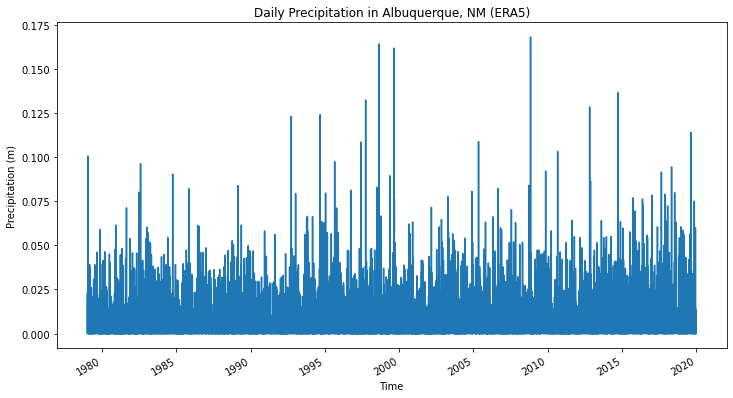

In [17]:
alb_era.plot(figsize=(12,6))
plt.title("Daily Precipitation in Albuquerque, NM (ERA5)")
plt.xlabel("Time")
plt.ylabel("Precipitation (m)")

In [16]:
#sw_precip = daily_precip_regrid.precip.sel(lon = slice(290,300), lat=slice(30,40))
#sw_precip.plot(figsize=(12,6))
#plt.title("Daily Precipitation in the SW USA (NOAA CPC)")
#plt.xlabel("Time")
#plt.ylabel("Precipitation (mm)")

Text(0, 0.5, 'Precipitation (m)')

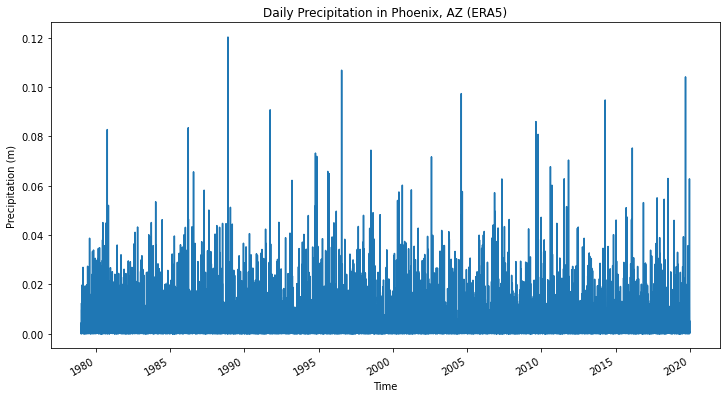

In [18]:
phoen_era = yearly_precip_regridded.tp.sel(lat='33.5', lon='292.5')
phoen_era.plot(figsize=(12,6))
plt.title("Daily Precipitation in Phoenix, AZ (ERA5)")
plt.xlabel("Time")
plt.ylabel("Precipitation (m)")

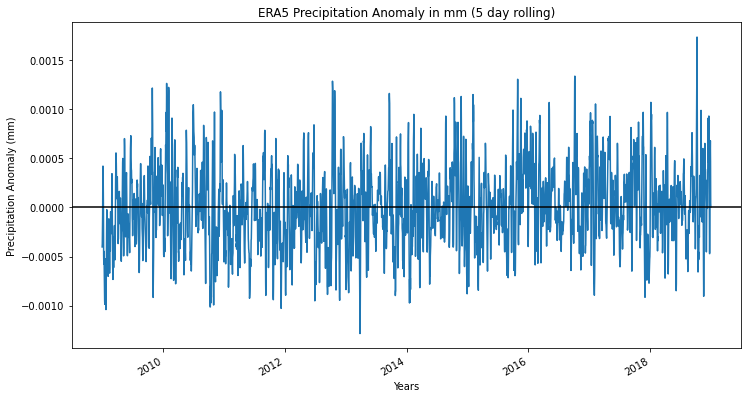

In [21]:
from pylab import rcParams
rcParams['figure.figsize'] = 12,6
precip_rolling_1D.sel(time=slice('2009-01-01T00:00:00.000000000','2019-01-01T00:00:00.000000000')).plot()
plt.ylabel('Precipitation Anomaly (mm)');
plt.xlabel('Years');
plt.title('ERA5 Precipitation Anomaly in mm (5 day rolling)');
plt.axhline(y = 0, color = 'k')
#plt.axhline(y = -0.5, color = 'blue')
#plt.axhline(y = 0.5, color = 'red')
#plt.legend([''])

#### NOAA CPC and ERA5 Precipitation Climatology and Anomalies

In [14]:
#NOAA CPC Precip data
US_lats = np.argwhere((daily_precip_regrid.lat.values >= 20) & (daily_precip_regrid.lat.values <= 60))
US_lons = np.argwhere((daily_precip_regrid.lon.values >= 230) & (daily_precip_regrid.lon.values <= 300))

#ERA5
#US_lats = np.argwhere((yearly_precip_regridded.lat.values >= 20) & (yearly_precip_regridded.lat.values <= 60))
#US_lons = np.argwhere((yearly_precip_regridded.lon.values >= 230) & (yearly_precip_regridded.lon.values <= 300))

In [15]:
US_precip_data = daily_precip_regrid.sel(lon = slice(230,300), lat=slice(20,60))
#US_precip_data = yearly_precip_regridded.sel(lon = slice(230,300), lat=slice(20,60))
US_TW_data = all_tw_regridded.sel(lon = slice(230,300), lat=slice(20,60))

In [16]:
US_TW_data = US_TW_data.sel(time = slice('1979-01-01T00:00:00.000000000','2019-12-21T00:00:00.000000000'))

In [33]:
#NOAA precip daily average - .precip
#ERA5 precip - .tp
NOAA_precip_mean = US_precip_data.precip.groupby('time.dayofyear').mean(dim='time')

#NOAA precip rolling mean
NOAA_rolling = US_precip_data.rolling(time = 30, center = True).mean('time')

In [34]:
#NOAA precipitation anomaly - removes seasonality
NOAA_precip_data_anom_smooth = US_precip_data.precip.groupby('time.dayofyear') - NOAA_rolling.groupby('time.dayofyear').mean(dim='time')
NOAA_precip_data_anom = US_precip_data.precip.groupby('time.dayofyear') - NOAA_precip_mean

#- US_precip_data.precip.groupby('time.dayofyear').mean(dim='time')


In [35]:
NOAA_precip_data_anom_JJA = NOAA_precip_data_anom.where(NOAA_precip_data_anom.time.dt.month.isin([6,7,8]),drop=True)

In [33]:
#precip_anom__mean = US_precip_data.mean(dim=('lon','lat'))
#NOAA_precip_rolling_1d = precip_anom__mean.rolling(time=5, center=True).mean('time')
#NOAA_precip_rolling = US_precip_data.rolling(time = 5, center = True).mean('time')

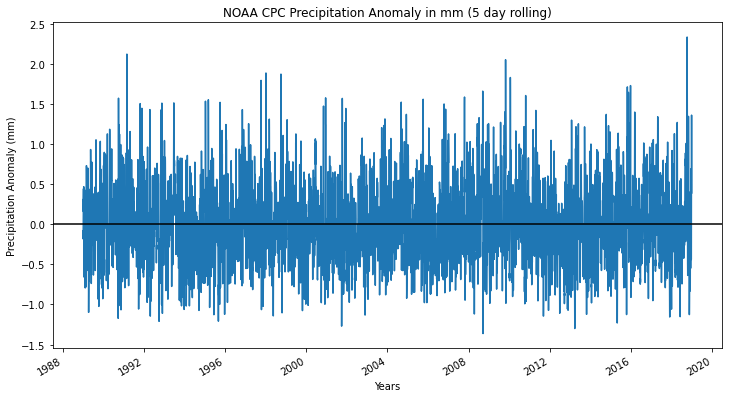

In [34]:
from pylab import rcParams
rcParams['figure.figsize'] = 12,6
NOAA_precip_rolling_1d.sel(time=slice('1989-01-01T00:00:00.000000000','2019-01-01T00:00:00.000000000')).plot()
plt.ylabel('Precipitation Anomaly (mm)');
plt.xlabel('Years');
plt.title('NOAA CPC Precipitation Anomaly in mm (5 day rolling)');
plt.axhline(y = 0, color = 'k')
#plt.axhline(y = -0.5, color = 'blue')
#plt.axhline(y = 0.5, color = 'red')
#plt.legend([''])

#### Wet Bulb Temp Anomalies and Climatologies

In [17]:
#daily average
TW_mean = US_TW_data.TW.groupby('time.dayofyear').mean(dim='time')

#rolling mean
TW_roll = US_TW_data.TW.rolling(time=30, center = True).mean('time')

In [18]:
#all_tw_regridded
US_TW_data_anom_smooth = US_TW_data.TW.groupby('time.dayofyear') - TW_roll.groupby('time.dayofyear').mean(dim='time')
US_TW_data_anom = US_TW_data.TW.groupby('time.dayofyear') - TW_mean

#US_TW_data.TW.groupby('time.dayofyear').mean(dim='time')

In [63]:
#US_TW_anom_JJA = US_TW_data_anom.where(US_TW_data_anom.time.dt.month.isin([6,7,8]),drop=True)

In [36]:
#TW_anom__mean = US_TW_data.mean(dim=('lon','lat'))
#TW_rolling_1d = TW_anom__mean.rolling(time=5, center=True).mean('time')
#TW_rolling = US_TW_data.rolling(time = 5, center = True).mean('time')

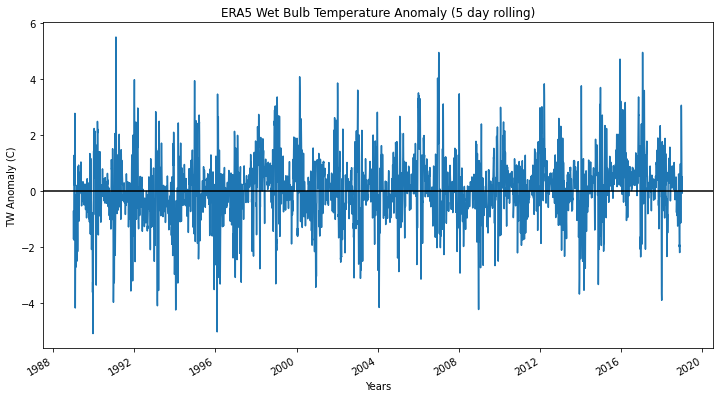

In [37]:
from pylab import rcParams
rcParams['figure.figsize'] = 12,6
TW_rolling_1d.sel(time=slice('1989-01-01T00:00:00.000000000','2019-01-01T00:00:00.000000000')).plot()
plt.ylabel('TW Anomaly (C)');
plt.xlabel('Years');
plt.title('ERA5 Wet Bulb Temperature Anomaly (5 day rolling)');
plt.axhline(y = 0, color = 'k')

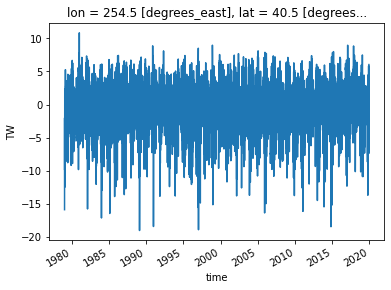

In [64]:
TW_mean_NYC = TW_mean.sel(lon=254.5,lat=40.5).TW
#TW_mean_NYC.plot(x='dayofyear')
TW_roll_NYC= TW_roll.sel(lon=254.5,lat=40.5)
#TW_roll_NYC.plot(x='time', figsize=(12,6))

US_TW_data_anom_smooth.sel(lon=254.5,lat=40.5).plot(x='time')
#US_TW_data_anom.sel(lon=254.5,lat=40.5).plot(x='time')

In [53]:
#pick a grid box, show mean TW and surrounding anomalies for seasons

#fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(12,6))
#axes.plot('dayofyear', 'TW_mean_NYC', color='magenta', label = 'Daily Mean')
#axes[0].fill_between(date, t_daily_min, t_daily_max, color='0.8', label = 'Daily Range')

#### 2m dry bulb temp climatologies and anomalies

In [65]:
#temp_dailymean
US_temp_data = temp_dailymean.sel(lon = slice(230,300), lat=slice(20,60))

#daily avg
US_temp_data_mean = US_temp_data.t2m.groupby('time.dayofyear').mean(dim='time')

#rolling avg
temp_rolling = US_temp_data.rolling(time=5, center=True).mean('time')

In [66]:
US_temp_anom_smooth = US_temp_data.t2m.groupby('time.dayofyear') - temp_rolling.groupby('time.dayofyear').mean(dim='time')
US_temp_anom = US_temp_data.t2m.groupby('time.dayofyear') - US_temp_data_mean

#- US_temp_data.t2m.groupby('time.dayofyear').mean(dim='time')

In [74]:
#US_temp_data

In [100]:
#temp_anom__mean = US_temp_data.mean(dim=('lon','lat'))
#temp_rolling_1d = temp_anom__mean.rolling(time=5, center=True).mean('time')
#temp_rolling = US_temp_data.rolling(time=5, center=True).mean('time')

In [75]:
#temp_rolling = US_temp_data.rolling(time=5, center=True).mean('time')
#temp_rolling_anom = temp_anom__mean - temp_rolling
#temp_rolling_anom

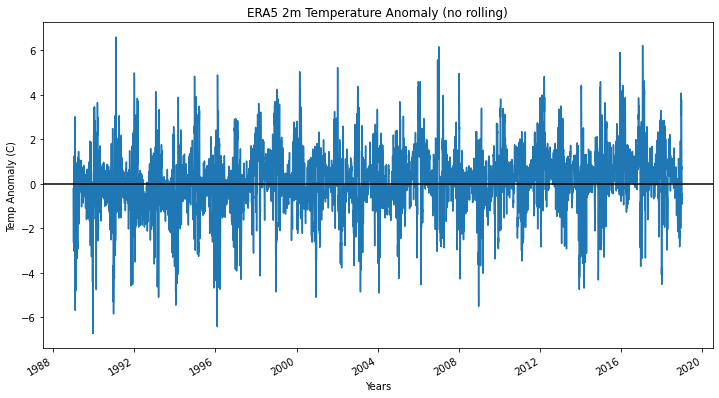

In [109]:
from pylab import rcParams
rcParams['figure.figsize'] = 12,6
temp_rolling_1d.sel(time=slice('1989-01-01T00:00:00.000000000','2019-01-01T00:00:00.000000000')).plot()
plt.ylabel('Temp Anomaly (C)');
plt.xlabel('Years');
plt.title('ERA5 2m Temperature Anomaly (no rolling)');
plt.axhline(y = 0, color = 'k')

# ERA5 TW and NOAA CPC Precip Difference analysis

In [36]:
US_precip_data_JJA = US_precip_data.where(US_precip_data.time.dt.month.isin([6,7,8]),drop=True)
US_precip_data_JJA = NOAA_precip_data_anom_smooth.where(NOAA_precip_data_anom_smooth.time.dt.month.isin([6,7,8]),drop=True)

US_TW_data_JJA = US_TW_data_anom_smooth.where(US_TW_data_anom_smooth.time.dt.month.isin([6,7,8]),drop=True)
#US_precip_data_JJA

NOAA_precip_data_anom_JJA = NOAA_precip_data_anom_smooth.where(NOAA_precip_data_anom.time.dt.month.isin([6,7,8]),drop=True).precip
#ERA_precip_data_anom_JJA = US_precip_data_anom_smooth.where(US_precip_data_anom.time.dt.month.isin([6,7,8]),drop=True)
US_TW_anom_JJA = US_TW_data_anom_smooth.where(US_TW_data_anom.time.dt.month.isin([6,7,8]),drop=True)

In [37]:
#percentile for all days - using regular data
percentile_cutoff_US_JJA = np.nanpercentile(NOAA_precip_data_anom_JJA, q=90, axis=0)  #US_precip_data_JJA for raw data
percentile_cutoff_TW_US_JJA = np.nanpercentile(US_TW_anom_JJA, q=90, axis=0) #US_TW_data_JJA for raw data

C:\Users\sojo9\anaconda3\envs\pangeo\lib\site-packages\numpy\lib\nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


In [28]:
#percentile of 5 day rolling anomaly
#percentile_cutoff_US_JJA = np.nanpercentile(NOAA_precip_rolling, q=90, axis=0)
#percentile_cutoff_TW_US_JJA = np.nanpercentile(US_TW_data_JJA.TW, q=90, axis=0)
US_precip_data_JJA

<xarray.Dataset>
Dimensions:    (time: 3772, lat: 40, lon: 70)
Coordinates:
  * lon        (lon) float64 230.5 231.5 232.5 233.5 ... 296.5 297.5 298.5 299.5
  * lat        (lat) float64 20.5 21.5 22.5 23.5 24.5 ... 56.5 57.5 58.5 59.5
    dayofyear  (time) int64 152 153 154 155 156 157 ... 238 239 240 241 242 243
  * time       (time) datetime64[ns] 1979-06-01 1979-06-02 ... 2019-08-31
Data variables:
    tp         (time, lat, lon) float32 -9.554e-05 -6.458e-05 ... 0.002724

In [79]:
#percentile of precipitation only on rainy days (only do if taking percentile off of raw data)
percentile_cutoff_US_JJA = np.zeros((NOAA_precip_data_anom_JJA.shape[1], NOAA_precip_data_anom_JJA.shape[2]))
#US_precip_data_JJA_pc = np.zeros((US_precip_data_JJA.shape[1], US_precip_data_JJA.shape[2]))
rain_threshold = 1
for i in range(NOAA_precip_data_anom_JJA.shape[1]):
    
    for j in range(NOAA_precip_data_anom_JJA.shape[2]):
        
        # Iterate through every point in the US data, and calculate the difference in mean 
        precip_data_for_coordinate = NOAA_precip_data_anom_JJA[:,i,j]
        idx_norain = np.squeeze(np.argwhere(np.array(precip_data_for_coordinate) <= rain_threshold))
        US_precip_data_JJA_pc = precip_data_for_coordinate[~idx_norain]
        
        percentile_cutoff_US_JJA[i][j] = np.nanpercentile(US_precip_data_JJA_pc, q=90)

C:\Users\sojo9\anaconda3\envs\pangeo\lib\site-packages\numpy\lib\nanfunctions.py:1559: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\sojo9\anaconda3\envs\pangeo\lib\site-packages\numpy\lib\nanfunctions.py:1560: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,


In [57]:
results_US_JJA = np.zeros((US_precip_data_JJA.precip.shape[1], US_precip_data_JJA.precip.shape[2]))
results_US_JJA_precip = np.zeros((US_precip_data_JJA.precip.shape[1], US_precip_data_JJA.precip.shape[2]))
results_US_JJA_median = np.zeros((US_precip_data_JJA.precip.shape[1], US_precip_data_JJA.precip.shape[2]))
US_median = np.zeros((US_precip_data_JJA.precip.shape[1], US_precip_data_JJA.precip.shape[2]))
US_mean = np.zeros((US_precip_data_JJA.precip.shape[1], US_precip_data_JJA.precip.shape[2]))
US_mean_precip = np.zeros((US_precip_data_JJA.precip.shape[1], US_precip_data_JJA.precip.shape[2]))
US_mean_extreme_precip = np.zeros((US_precip_data_JJA.precip.shape[1], US_precip_data_JJA.precip.shape[2]))

mann_whitney_results = np.zeros((US_precip_data_JJA.precip.shape[1], US_precip_data_JJA.precip.shape[2]))
significant_mask = np.zeros((US_precip_data_JJA.precip.shape[1], US_precip_data_JJA.precip.shape[2]))
total_TW_nonextreme = list()
total_TW_extreme = list()
buffer = 3

for i in range(US_precip_data_JJA.precip.shape[1]):
    
    for j in range(US_precip_data_JJA.precip.shape[2]):
        
        # Iterate through every point in the US data, and calculate the difference in mean 
        TW_data_for_coordinate = US_TW_anom_JJA[:,j,i]
        precip_data_for_coordinate = NOAA_precip_data_anom_JJA[:,i,j]
        idx = np.squeeze(np.argwhere(np.array(precip_data_for_coordinate) >= percentile_cutoff_US_JJA[i][j])) + buffer #90 percentile assignment
        idx = idx[idx<=3771] 
        idx_TW = np.squeeze(np.argwhere(np.array(TW_data_for_coordinate) >= percentile_cutoff_TW_US_JJA[j][i])) + buffer # 90% for TW
        idx_TW = idx_TW[idx_TW<=3771]
        total_TW_nonextreme.append(TW_data_for_coordinate[~idx]) #days that aren't extreme
        total_TW_extreme.append(TW_data_for_coordinate[idx]) #days that are (in index)
        
        if TW_data_for_coordinate[idx].size != 0 and TW_data_for_coordinate[idx].size >= 20 and ks_2samp(TW_data_for_coordinate[~idx], TW_data_for_coordinate[idx]).pvalue <= 0.05:
            significant_mask[i][j] = 1
        else:
            significant_mask[i][j] = 0
        US_mean[i][j] = np.mean(TW_data_for_coordinate)
        US_mean_precip[i][j] = np.mean(precip_data_for_coordinate)
        US_mean_extreme_precip[i][j] = np.mean(precip_data_for_coordinate[idx_TW])
        US_median[i][j] = np.median(TW_data_for_coordinate)
        results_US_JJA[i][j] = np.mean(TW_data_for_coordinate[idx]) - np.mean(TW_data_for_coordinate[~idx])
        results_US_JJA_precip[i][j] = np.mean(precip_data_for_coordinate[idx_TW]) - np.mean(precip_data_for_coordinate[~idx_TW])
        results_US_JJA_median[i][j] = (np.median(TW_data_for_coordinate[idx]) - np.median(TW_data_for_coordinate[~idx])) #/ np.median(TW_data_for_coordinate[~idx])

C:\Users\sojo9\anaconda3\envs\pangeo\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\sojo9\anaconda3\envs\pangeo\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\sojo9\anaconda3\envs\pangeo\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\sojo9\anaconda3\envs\pangeo\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\sojo9\anaconda3\envs\pangeo\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\sojo9\anaconda3\envs\pangeo\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encounte

In [43]:
#NOAA_precip_data_anom

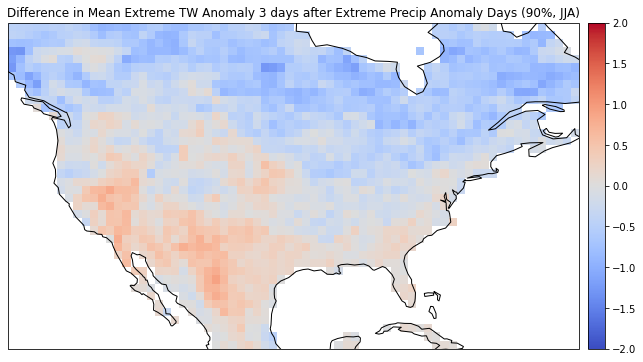

In [59]:
fig= plt.figure(figsize=(12,6))
ax = plt.axes(projection=ccrs.PlateCarree())
cm = plt.cm.get_cmap('BrBG')
res = '110m'
ax.add_feature(cfeature.COASTLINE.with_scale(res))
#ax.add_feature(cartopy.feature.BORDERS)
#ax.add_feature(cartopy.feature.LAND, edgecolor='black')
#ax.add_feature(cartopy.feature.STATES, edgecolor='white')
#gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
 #                 linewidth=1, color='gray', alpha=0.5, linestyle='--', zorder=10)
sc = plt.pcolormesh(yearly_precip_regridded.lon.values[US_lons[:,0]], yearly_precip_regridded.lat.values[US_lats[:,0]], results_US_JJA,transform=ccrs.PlateCarree(), cmap='coolwarm') #coolwarm, BrBG
#plt.pcolormesh(yearly_precip_regridded.lon.values[US_lons[:,0]], yearly_precip_regridded.lat.values[US_lats[:,0]], np.ma.masked_less(significant_mask, 0), facecolor = 'None', edgecolors = None)
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
ax.set_title('Difference in Mean Extreme TW Anomaly 3 days after Extreme Precip Anomaly Days (90%, JJA)')
#Difference in Mean Wet Bulb Temperature Anomaly 1 day before Extreme Precipitation Anomaly Days
#Difference in Mean Extreme Precipitation Anomaly 2 days before Extreme Wet Bulb Temperature Anomaly Days
plt.colorbar(sc, cax=cax) # Similar to fig.colorbar(im, cax = cax)
plt.clim(-2, 2)
#plt.savefig('/RainHeatData/median_temp_diff_USA_signficant.png')
plt.show()

## Global region difference maps

In [16]:
#Northern Hemisphere - NOAA
#noaalats = np.argwhere((daily_precip_regrid.lat.values >= 0) & (daily_precip_regrid.lat.values <= 90))
#noaalons = np.argwhere((daily_precip_regrid.lon.values >= 0) & (daily_precip_regrid.lon.values <= 360))
#noaaprecip_data = daily_precip_regrid.sel(lon = slice(0,360), lat=slice(0,90)) #yearly_precip_regridded
#TW_data = all_tw_regridded.sel(lon = slice(0,360), lat=slice(0,90))

#ERA5 Northern Hemisphere
lats = np.argwhere((yearly_precip_regridded.lat.values >= 0) & (yearly_precip_regridded.lat.values <= 90))
lons = np.argwhere((yearly_precip_regridded.lon.values >= 0) & (yearly_precip_regridded.lon.values <= 360))
precip_data = yearly_precip_regridded.sel(lon = slice(0,360), lat=slice(0,90)) #yearly_precip_regridded
TW_data = all_tw_regridded.sel(lon = slice(0,360), lat=slice(0,90))
temp_data = temp_dailymean.sel(lon = slice(0,360), lat=slice(0,90))

#Southern Hemisphere
#lats = np.argwhere((yearly_precip_regridded.lat.values >= -90) & (yearly_precip_regridded.lat.values <= 0))
#lons = np.argwhere((yearly_precip_regridded.lon.values >= 0) & (yearly_precip_regridded.lon.values <= 360))
#precip_data = yearly_precip_regridded.sel(lon = slice(0,360), lat=slice(-90,0)) #yearly_precip_regridded
#TW_data = all_tw_regridded.sel(lon = slice(0,360), lat=slice(-90,0))
#temp_data = temp_dailymean.sel(lon = slice(0,360), lat=slice(-90,0))

In [17]:
#cut TW time so data are the same
TW_data = TW_data.sel(time = slice('1979-01-01T00:00:00.000000000','2019-12-21T00:00:00.000000000'))
precip_data = precip_data.sel(time = slice('1979-01-01T00:00:00.000000000','2019-12-21T00:00:00.000000000'))
#noaaprecip_data = noaaprecip_data.sel(time = slice('1979-01-01T00:00:00.000000000','2019-12-21T00:00:00.000000000'))
temp_data = temp_data.sel(time = slice('1979-01-01T00:00:00.000000000','2019-12-21T00:00:00.000000000'))

#select JJA months - summer for North Hem
#noaaprecip_data_JJA = noaaprecip_data.where(precip_data.time.dt.month.isin([6,7,8]),drop=True).precip
precip_data_JJA = precip_data.where(precip_data.time.dt.month.isin([6,7,8]),drop=True) #tp for ERA5, precip for NOAA
TW_data_JJA = TW_data.where(TW_data.time.dt.month.isin([6,7,8]),drop=True).TW
temp_data_JJA = temp_data.where(temp_data.time.dt.month.isin([6,7,8]),drop=True).t2m 

#select DJF months - summer for Southern Hem
#precip_data_JJA = precip_data.where(precip_data.time.dt.month.isin([12,1,2]),drop=True) #tp for ERA5
#TW_data_JJA = TW_data.where(TW_data.time.dt.month.isin([12,1,2]),drop=True).TW
#temp_data_JJA = temp_data.where(temp_data.time.dt.month.isin([12,1,2]),drop=True).t2m 

## Autocorrelations

In [21]:
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
import matplotlib.pyplot as plt

In [65]:
###autocorrelation###
#calculate autocorrelations
#sm.tsa.acf(precip_data_JJA)

precip_JJA = yearly_precip_regridded.where(yearly_precip_regridded.time.dt.month.isin([6,7,8]),drop=True)

precip_data_1 = precip_JJA.where(precip_JJA.time.dt.year.isin([2019]),drop=True)
precip_data_2 = precip_JJA.where(precip_JJA.time.dt.year.isin([1998]),drop=True)
#noaaprecip_data_1 = noaaprecip_data_JJA.where(noaaprecip_data_JJA.time.dt.year.isin([2019]),drop=True)
#precip_data_1
#pd.plotting.lag_plot(precip_data_1, lag=15)
#pd.plotting.lag_plot(noaaprecip_data_1, lag=15)

In [66]:
#2019
#plot_acf(precip_data_1.time,lags=15)

#sm.tsa.acf(precip_data_1.time, nlags=15) #correlation coefficients
#>1 week is significantly correlated (~9 days)
#makes sense -- scale of weather (~7 days)

#pick a year, 1 3 and 7 day lags
#create map at each grid point with correlation coefficient
#3 maps with each lag -- loop through
# initialize empty array
#for i,j
#select grid point
#save into new array

corr_precip = np.zeros((precip_data_2.shape[1], precip_data_2.shape[2]))
lag = 3
for i in range(precip_data_2.shape[1]):
    
    for j in range(precip_data_2.shape[2]):
         
        corr_data_for_coordinate = precip_data_2[:,i,j]
        corr =np.array(sm.tsa.acf(corr_data_for_coordinate,nlags=lag))
        corr1=corr[lag]
        #idx = np.squeeze(np.argwhere(np.array(precip_data_for_coordinate) >= percentile_cutoff_JJA[i][j]))
        
        corr_precip[i][j] = corr1

C:\Users\sojo9\anaconda3\envs\pangeo\lib\site-packages\statsmodels\tsa\stattools.py:681: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


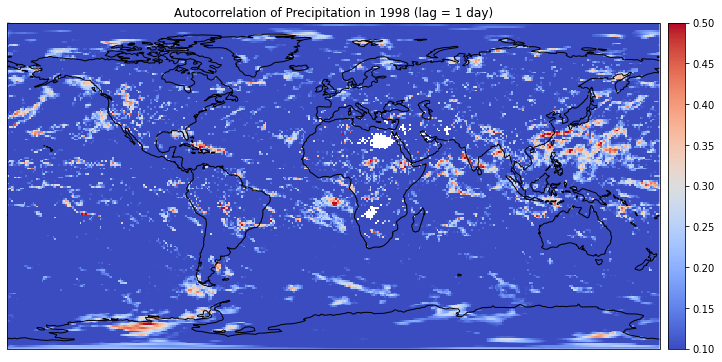

In [67]:
lats = np.argwhere((yearly_precip_regridded.lat.values >= -90) & (yearly_precip_regridded.lat.values <= 90))
lons = np.argwhere((yearly_precip_regridded.lon.values >= 0) & (yearly_precip_regridded.lon.values <= 360))

precip_data = yearly_precip_regridded.sel(lon = slice(0,360), lat=slice(-90,90))
TW_data = all_tw_regridded.sel(lon = slice(0,360), lat=slice(0,90))

fig= plt.figure(figsize=(12,6))
ax = plt.axes(projection=ccrs.PlateCarree())
cm = plt.cm.get_cmap('BrBG')
res = '110m'
ax.add_feature(cfeature.COASTLINE.with_scale(res))
#gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
 #                 linewidth=1, color='gray', alpha=0.5, linestyle='--', zorder=10)
sc = plt.pcolormesh(yearly_precip_regridded.lon.values[lons[:,0]], yearly_precip_regridded.lat.values[lats[:,0]], corr_precip,transform=ccrs.PlateCarree(), cmap='coolwarm') #coolwarm, BrBG
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
ax.set_title('Autocorrelation of Precipitation in 1998 (lag = 1 day)')
plt.colorbar(sc, cax=cax) # Similar to fig.colorbar(im, cax = cax)
plt.clim(0.1, 0.5)
#plt.savefig('/RainHeatData/2019_precip_acf.png')
plt.show()

#plt.pcolormesh(corr_precip)

In [146]:
# fig= plt.figure(figsize=(12,6))

central_lat = 90
central_lon = 180
extent = [0, 180, 0, 360]
#central_lon = np.mean(extent[:2])
#central_lat = np.mean(extent[2:])

plt.figure(figsize=(12, 6))
#ax = plt.axes(projection=ccrs.PlateCarree(central_lon, central_lat))
#ax.set_extent(extent)

ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAND, edgecolor='black')
ax.add_feature(cartopy.feature.LAKES, edgecolor='black')
ax.add_feature(cartopy.feature.RIVERS)
ax.gridlines()

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=90))
ax.coastlines()
ax.set_global()
ax.set_extent(extent)
#ax = plt.axes(projection=ccrs.PlateCarree())
cm = plt.cm.get_cmap('coolwarm')
#cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
res = '110m'
#ax.add_feature(cfeature.COASTLINE.with_scale(res))
mesh = plt.pcolormesh(corr_precip, cmap='bwr',transform=ccrs.PlateCarree())
#ax.plt.colorbar(mesh)
             #, cax=cax)

#expectations: monsoon or clear wet season should have high autocorrelation?

KeyboardInterrupt: 

Exception ignored in: 'pyproj._datadir.pyproj_log_function'
Traceback (most recent call last):
  File "C:\Users\sojo9\anaconda3\envs\pangeo\lib\logging\__init__.py", line 1424, in debug
    def debug(self, msg, *args, **kwargs):
KeyboardInterrupt: 


Error in callback <function flush_figures at 0x00000201092ED1F0> (for post_execute):


KeyboardInterrupt: 

In [97]:
corr

percentile_cutoff_US_JJA = np.zeros((NOAA_precip_data_anom_JJA.shape[1], NOAA_precip_data_anom_JJA.shape[2]))
#US_precip_data_JJA_pc = np.zeros((US_precip_data_JJA.shape[1], US_precip_data_JJA.shape[2]))
rain_threshold = 1
for i in range(NOAA_precip_data_anom_JJA.shape[1]):
    
    for j in range(NOAA_precip_data_anom_JJA.shape[2]):
        
        # Iterate through every point in the US data, and calculate the difference in mean 
        precip_data_for_coordinate = NOAA_precip_data_anom_JJA[:,i,j]
        idx_norain = np.squeeze(np.argwhere(np.array(precip_data_for_coordinate) <= rain_threshold))
        US_precip_data_JJA_pc = precip_data_for_coordinate[~idx_norain]
        
        percentile_cutoff_US_JJA[i][j] = np.nanpercentile(US_precip_data_JJA_pc, q=90)

array([1.        , 0.00788017])

array([ 1.        ,  0.71329913,  0.36139588,  0.08351465, -0.0824636 ,
       -0.10283391, -0.0812629 , -0.05994351, -0.05838697, -0.07393187,
       -0.11803138, -0.14104252, -0.15027006, -0.11172135, -0.10890266,
       -0.11888404])

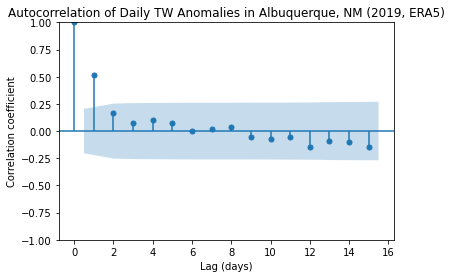

In [28]:
##albuquerque case##
#precip_JJA = yearly_precip_regridded.where(yearly_precip_regridded.time.dt.month.isin([6,7,8]),drop=True)
#precip_JJA = yearly_precip_regridded.where(yearly_precip_regridded.time.dt.month.isin([6,7,8]),drop=True)

#all_tw_regridded

alb= precip_data_anom.sel(lat='35.5', lon='285.5')
alb_TW= TW_data_anom.sel(lat='35.5', lon='285.5')
#alb_era = yearly_precip_regridded.tp.sel(lat='35.5', lon='285.5')
#alb_era_monthly = alb_era.groupby('time.month').mean(dim='time')

#alb_mean = alb.groupby('time.dayofyear').mean(dim='time')
#5 day rolling mean
#alb_rolling = alb.rolling(time = 30, center = True).mean('time')

#anomaly
#alb_data_anom = alb.groupby('time.dayofyear') - alb_rolling.groupby('time.dayofyear').mean(dim='time')

#plot_acf(alb.time,lags=100)

#pd.plotting.lag_plot(alb_data_anom.time, lag=1)

alb_TW_2019 = alb_TW.where(alb_TW.time.dt.year.isin([2019]),drop=True)
alb_TW_1998 = alb_TW.where(alb_TW.time.dt.year.isin([1998]),drop=True)

tsaplots.plot_acf(alb_TW_2019,lags=15)
plt.title("Autocorrelation of Daily TW Anomalies in Albuquerque, NM (2019, ERA5)")
plt.xlabel("Lag (days)")
plt.ylabel("Correlation coefficient")

sm.tsa.acf(alb_TW_1998, nlags=15)

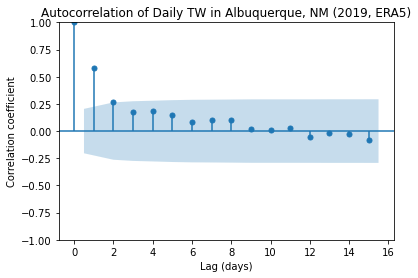

In [66]:
alb_TW_2019 = alb_TW.where(alb_TW.time.dt.year.isin([2019]),drop=True)
tsaplots.plot_acf(alb_TW_2019,lags=15)
plt.title("Autocorrelation of Daily TW in Albuquerque, NM (2019, ERA5)")
plt.xlabel("Lag (days)")
plt.ylabel("Correlation coefficient")

sm.tsa.acf(alb_TW_2019, nlags=15)
#plt.savefig('/RainHeatData/Figures/albuquerque_dailyTW2019_acf.png')

array([ 1.        ,  0.17960391,  0.03226624, -0.01310122, -0.1153358 ,
       -0.12384246, -0.13460509,  0.0076789 ,  0.09688742,  0.10614104,
        0.1096082 , -0.08034608, -0.02295938, -0.06166323, -0.02993045,
       -0.01767574])

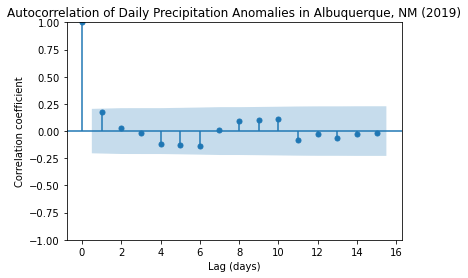

In [29]:
###ERA5 precip alb case###
alb= precip_data_anom.sel(lat='35.5', lon='285.5')
alb_TW= TW_data_anom.sel(lat='35.5', lon='285.5')

alb_2019 = alb.where(alb.time.dt.year.isin([2019]),drop=True) #raw precip
#alb_2019 = alb_data_anom.where(alb.time.dt.year.isin([2019]),drop=True) #precip anom

tsaplots.plot_acf(alb_2019,lags=15)
plt.title("Autocorrelation of Daily Precipitation Anomalies in Albuquerque, NM (2019)")
plt.xlabel("Lag (days)")
plt.ylabel("Correlation coefficient")

sm.tsa.acf(alb_2019, nlags=15)
#plt.savefig('/RainHeatData/Figures/albuquerque_dailyprecip2019_acf.png')

array([ 1.        ,  0.05664246, -0.10496554, -0.01755026,  0.03187298,
       -0.04521957, -0.00977879,  0.0192418 ,  0.13657943,  0.12055758,
       -0.22616844,  0.08394341, -0.09747529, -0.11097077, -0.01421615,
        0.08965484])

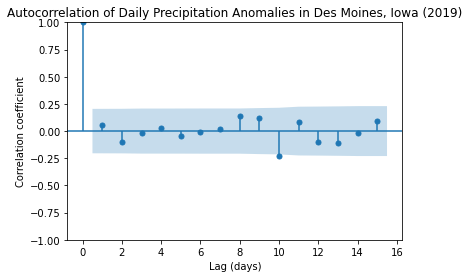

In [30]:
##Des Moines, Iowa case##
DM= precip_data_anom.sel(lat='41.5', lon='273.5')
DM_TW = TW_data_anom.sel(lat='41.5', lon='273.5')
#alb_era = yearly_precip_regridded.tp.sel(lat='35.5', lon='285.5')
#alb_era_monthly = alb_era.groupby('time.month').mean(dim='time')

#DM_mean = DM.groupby('time.dayofyear').mean(dim='time')
#5 day rolling mean
#DM_rolling = DM.rolling(time = 30, center = True).mean('time')

#anomaly
#DM_data_anom = DM.groupby('time.dayofyear') - DM_rolling.groupby('time.dayofyear').mean(dim='time')

#plot_acf(alb.time,lags=100)

DM_2019 = DM.where(DM.time.dt.year.isin([2019]),drop=True) #raw precip
DM_TW_2019 = DM_TW.where(DM_TW.time.dt.year.isin([2019]),drop=True)

tsaplots.plot_acf(DM_2019,lags=15)
plt.title("Autocorrelation of Daily Precipitation Anomalies in Des Moines, Iowa (2019)")
plt.xlabel("Lag (days)")
plt.ylabel("Correlation coefficient")

sm.tsa.acf(DM_2019, nlags=15)

#pd.plotting.lag_plot(DM_data_anom, lag=1)
#plt.savefig('/RainHeatData/Figures/desmoines_dailyprecip2019_acf.png')

array([ 1.        ,  0.63613788,  0.29131669,  0.17972927,  0.10220347,
        0.02005562,  0.01554796,  0.12765947,  0.22756878,  0.2043437 ,
        0.12705506,  0.01088538, -0.09081021, -0.07823005, -0.00116327,
       -0.03912425])

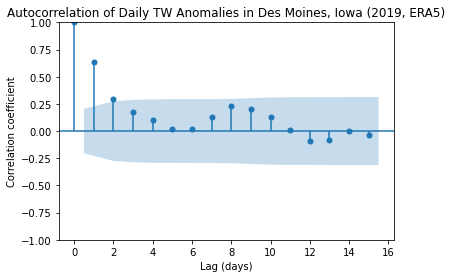

In [31]:
#DM TW Autocorrelation

tsaplots.plot_acf(DM_TW_2019,lags=15)
plt.title("Autocorrelation of Daily TW Anomalies in Des Moines, Iowa (2019, ERA5)")
plt.xlabel("Lag (days)")
plt.ylabel("Correlation coefficient")

sm.tsa.acf(DM_TW_2019, nlags=15)

array([ 1.        ,  0.53523135,  0.18442905,  0.07863593,  0.10067779,
        0.14343182,  0.07622946,  0.02955906,  0.06035026,  0.16772982,
        0.13570748,  0.07403819,  0.00158307, -0.03297616,  0.10392271,
        0.08511514])

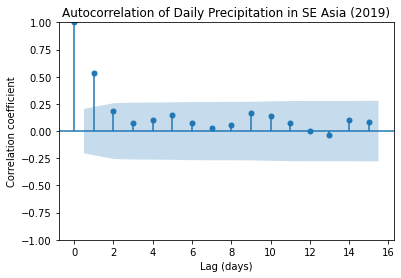

In [19]:
###ERA5 precip alb case###
SEAsia= precip_data_JJA.sel(lat='20.5', lon='80.5')
SEAsia_TW= TW_data_JJA.sel(lat='20.5', lon='80.5')

SEAsia_2019 = SEAsia.where(SEAsia.time.dt.year.isin([2019]),drop=True) #raw precip
SEAsia_TW_2019 = SEAsia_TW.where(SEAsia_TW.time.dt.year.isin([2019]),drop=True)

tsaplots.plot_acf(SEAsia_2019,lags=15)
plt.title("Autocorrelation of Daily Precipitation in SE Asia (2019)")
plt.xlabel("Lag (days)")
plt.ylabel("Correlation coefficient")

sm.tsa.acf(SEAsia_2019, nlags=15)
#plt.savefig('/RainHeatData/Figures/seasia_dailyprecipitation2019_acf.png')

array([ 1.        ,  0.57892262,  0.46070944,  0.39250029,  0.26177254,
        0.17875387,  0.1582437 ,  0.03240492, -0.00686037, -0.05971883,
       -0.03201722,  0.03103525,  0.02619588,  0.03870769,  0.02440059,
        0.00931205])

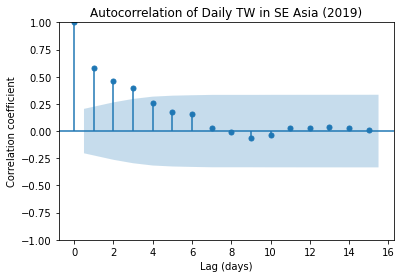

In [20]:
tsaplots.plot_acf(SEAsia_TW_2019,lags=15)
plt.title("Autocorrelation of Daily TW in SE Asia (2019)")
plt.xlabel("Lag (days)")
plt.ylabel("Correlation coefficient")

sm.tsa.acf(SEAsia_TW_2019, nlags=15)

array([ 1.        ,  0.28164951,  0.04069421, -0.06993062, -0.01647895,
        0.09345029, -0.03623057,  0.01775179,  0.0388728 ,  0.16990443,
        0.06084137,  0.0257083 , -0.0405875 , -0.00638575,  0.0760869 ,
       -0.07096958])

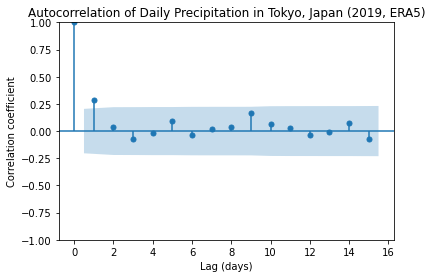

In [22]:
##Tokyo case##
Tokyo= precip_data_JJA.sel(lat='35.5', lon='139.5')
Tokyo_TW= TW_data_JJA.sel(lat='35.5', lon='139.5')

#Tokyo_mean = Tokyo.groupby('time.dayofyear').mean(dim='time')
#5 day rolling mean
#Tokyo_rolling = Tokyo.rolling(time = 30, center = True).mean('time')

#anomaly
#Tokyo_data_anom = Tokyo.groupby('time.dayofyear') - Tokyo_rolling.groupby('time.dayofyear').mean(dim='time')

Tokyo_2019 = Tokyo.where(Tokyo.time.dt.year.isin([2019]),drop=True) #raw precip
Tokyo_TW_2019 = Tokyo_TW.where(Tokyo_TW.time.dt.year.isin([2019]),drop=True)

tsaplots.plot_acf(Tokyo_2019,lags=15)
plt.title("Autocorrelation of Daily Precipitation in Tokyo, Japan (2019, ERA5)")
plt.xlabel("Lag (days)")
plt.ylabel("Correlation coefficient")

sm.tsa.acf(Tokyo_2019, nlags=15)
#plt.savefig('/RainHeatData/Figures/tokyo_dailyprecipitation2019_acf.png')

array([1.        , 0.91467212, 0.85742151, 0.77427297, 0.72443256,
       0.70210851, 0.69624157, 0.65655877, 0.60618692, 0.54845748,
       0.4959607 , 0.45927085, 0.43902   , 0.40716142, 0.37872131,
       0.34308613])

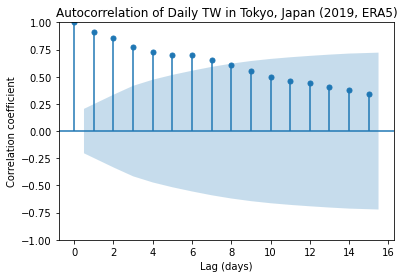

In [23]:
tsaplots.plot_acf(Tokyo_TW_2019,lags=15)
plt.title("Autocorrelation of Daily TW in Tokyo, Japan (2019, ERA5)")
plt.xlabel("Lag (days)")
plt.ylabel("Correlation coefficient")

sm.tsa.acf(Tokyo_TW_2019, nlags=15)

## Global Difference Maps

In [18]:
#daily average
precip_mean = precip_data_JJA.groupby('time.dayofyear').mean(dim='time')
#30 day rolling mean
precip_rolling = precip_data_JJA.rolling(time = 30, center = True).mean('time')

#anomaly
precip_data_anom = precip_data_JJA.groupby('time.dayofyear') - precip_rolling.groupby('time.dayofyear').mean(dim='time') #or .tp for ERA5 precip
#precip_data_anom = precip_data_JJA.groupby('time.dayofyear') - precip_mean

#precip_anom__mean = precip_data_anom.mean(dim=('lon','lat'))
#precip_rolling_1D = precip_anom__mean.rolling(time=5, center=True).mean('time')
#precip_rolling = precip_data_anom.rolling(time = 5, center = True).mean('time')

In [19]:
#daily average
TW_mean = TW_data_JJA.groupby('time.dayofyear').mean(dim='time')
#rolling mean
TW_rolling = TW_data_JJA.rolling(time = 30, center = True).mean('time')

#anomalies -- with 5 day smoothed climatology and without
TW_data_anom = TW_data_JJA.groupby('time.dayofyear') - TW_rolling.groupby('time.dayofyear').mean(dim='time')
#TW_data_anom = TW_data_JJA.groupby('time.dayofyear') - TW_mean

#TW_anom__mean = TW_data.mean(dim=('lon','lat'))
#TW_rolling_1d = TW_anom__mean.rolling(time=5, center=True).mean('time')
#TW_rolling = TW_data_anom.rolling(time = 5, center = True).mean('time')

In [20]:
#daily average
temp_mean = temp_data_JJA.groupby('time.dayofyear').mean(dim='time')
#rolling mean
temp_rolling = temp_data_JJA.rolling(time = 30, center = True).mean('time')

#anomalies -- with 5 day smoothed climatology and without
temp_data_anom = temp_data_JJA.groupby('time.dayofyear') - temp_rolling.groupby('time.dayofyear').mean(dim='time')
#TW_data_anom = TW_data_JJA.groupby('time.dayofyear') - TW_mean

#TW_anom__mean = TW_data.mean(dim=('lon','lat'))
#TW_rolling_1d = TW_anom__mean.rolling(time=5, center=True).mean('time')
#TW_rolling = TW_data_anom.rolling(time = 5, center = True).mean('time')

In [24]:
TW_data_for_coordinate = TW_data_anom[:,j,i]
precip_data_for_coordinate = precip_data_anom[:,i,j]
idx = np.squeeze(np.argwhere(np.array(precip_data_for_coordinate) >= percentile_cutoff_JJA[i][j])) + buffer #90 percentile assignment
#idx = idx[idx<=3771] - JJA
idx = idx[idx<=3689] 
idx_TW = np.squeeze(np.argwhere(np.array(TW_data_for_coordinate) >= percentile_cutoff_TW_JJA[j][i])) + buffer # 90% for TW
#idx_TW = idx_TW[idx_TW<=3771] - JJA
idx_TW = idx_TW[idx_TW<=3689]
results_JJA_precip[i][j] = np.mean(precip_data_for_coordinate[idx_TW]) - np.mean(precip_data_for_coordinate[~idx_TW])

NameError: name 'j' is not defined

In [21]:
#percentile thresholds for anomalies
percentile_cutoff_JJA = np.nanpercentile(precip_data_anom, q=90, axis=0)
percentile_cutoff_TW_JJA = np.nanpercentile(TW_data_anom, q=90, axis=0)
percentile_cutoff_temp_JJA = np.nanpercentile(temp_data_anom, q=90, axis=0)

In [22]:
#### Percentile thresholds for raw data ####

#precip_data_JJA = precip_data.where(precip_data.time.dt.month.isin([6,7,8]),drop=True) #tp for ERA5, precip for NOAA
#TW_data_JJA = TW_data.where(TW_data.time.dt.month.isin([6,7,8]),drop=True).TW

#raw_percentile_cutoff_JJA = np.nanpercentile(precip_data_JJA, q=90, axis=0)
#raw_percentile_cutoff_TW_JJA = np.nanpercentile(TW_data_JJA, q=90, axis=0)

#percentile of wet days >1 mm 
raw_percentile_cutoff_JJA = np.zeros((precip_data_JJA.shape[1], precip_data_JJA.shape[2]))
raw_percentile_cutoff_TW_JJA = np.zeros((precip_data_JJA.shape[1], precip_data_JJA.shape[2]))
raw_percentile_cutoff_temp_JJA = np.zeros((precip_data_JJA.shape[1], precip_data_JJA.shape[2]))

rain_threshold = 1
for i in range(precip_data_JJA.shape[1]):
    
    for j in range(precip_data_JJA.shape[2]):
        
        precip_data_for_coordinate = precip_data_JJA[:,i,j]
        TW_data_for_coordinate = TW_data_JJA[:,j,i]
        temp_data_for_coordinate = temp_data_JJA[:,i,j]
        idx_norain = np.squeeze(np.argwhere(np.array(precip_data_for_coordinate) <= rain_threshold))
        precip_data_JJA_pc = precip_data_for_coordinate[~idx_norain]
        TW_data_JJA_pc = TW_data_for_coordinate
        temp_data_JJA_pc = temp_data_for_coordinate
        
        raw_percentile_cutoff_JJA[i][j] = np.nanpercentile(precip_data_JJA_pc, q=90)
        raw_percentile_cutoff_TW_JJA[i][j] = np.nanpercentile(TW_data_JJA_pc, q=90)
        raw_percentile_cutoff_temp_JJA[i][j] = np.nanpercentile(temp_data_JJA_pc, q=90)

C:\Users\sojo9\anaconda3\envs\pangeo\lib\site-packages\numpy\lib\nanfunctions.py:1559: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [23]:
# set the colormap and centre the colorbar
class MidpointNormalize(colors.Normalize):
#Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)
#e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100)

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)
    def __call__(self, value, clip=None):
    # I’m ignoring masked values and all kinds of edge cases to make a
    # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

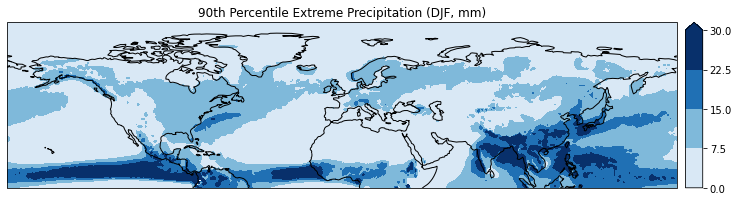

In [60]:
#### Percentile Threshold Maps - precipitation ####
lats = np.argwhere((precip_data_JJA.lat.values >= 0) & (precip_data_JJA.lat.values <= 90))
lons = np.argwhere((precip_data_JJA.lon.values >= 0) & (precip_data_JJA.lon.values <= 360))

levels = np.linspace(0, 30, 5)

#precip_data = yearly_precip_regridded.sel(lon = slice(0,360), lat=slice(0,90))
#TW_data = all_tw_regridded.sel(lon = slice(0,360), lat=slice(0,90))

fig= plt.figure(figsize=(12,6))
ax = plt.axes(projection=ccrs.PlateCarree())
cm = plt.cm.get_cmap('BrBG')
res = '110m'
ax.add_feature(cfeature.COASTLINE.with_scale(res))

#gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
#                 linewidth=1, color='gray', alpha=0.5, linestyle='--', zorder=10)

#sc = plt.pcolormesh(precip_data_JJA.lon.values[lons[:,0]], precip_data_JJA.lat.values[lats[:,0]], percentile_cutoff_TW_JJA,transform=ccrs.PlateCarree(), cmap='seismic') #coolwarm, BrBG
sc = plt.contourf(precip_data_JJA.lon.values[lons[:,0]], precip_data_JJA.lat.values[lats[:,0]],raw_percentile_cutoff_JJA, cmap='Blues', levels=levels, extend="max") #coolwarm, BrBG

cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
ax.set_title('90th Percentile Extreme Precipitation (DJF, mm)')
plt.colorbar(sc, cax=cax,norm = colors.LogNorm(),extend='max') # Similar to fig.colorbar(im, cax = cax)
plt.clim(0, 25)
#plt.savefig('/RainHeatData/FinalFigs/Shem_90pc_precip_contour_coastlines.png')
plt.show()

### coloring options ###
#bin it
#shade out low values (<10 mm grey out)
#contour fill (contourf)
#OR#
#map.sel(>0<.5) plot each individually as a pcolormesh and plot

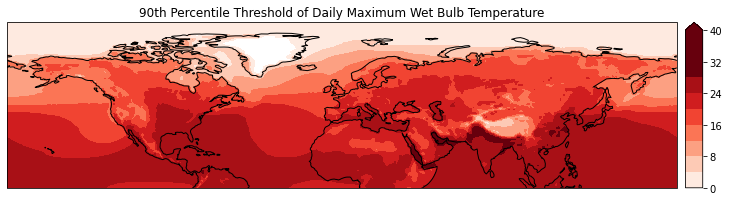

In [62]:
#### Percentile Threshold Maps - wet bulb temperature ####

lats = np.argwhere((yearly_precip_regridded.lat.values >= 0) & (yearly_precip_regridded.lat.values <= 90))
lons = np.argwhere((yearly_precip_regridded.lon.values >= 0) & (yearly_precip_regridded.lon.values <= 360))

levels = np.linspace(0, 40,11)

precip_data = yearly_precip_regridded.sel(lon = slice(0,360), lat=slice(0,90))
TW_data = all_tw_regridded.sel(lon = slice(0,360), lat=slice(0,90))

fig= plt.figure(figsize=(12,6))
ax = plt.axes(projection=ccrs.PlateCarree())
cm = plt.cm.get_cmap('BrBG')
res = '110m'
ax.add_feature(cfeature.COASTLINE.with_scale(res))
#gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
 #                 linewidth=1, color='gray', alpha=0.5, linestyle='--', zorder=10)
#sc = plt.contourf(yearly_precip_regridded.lon.values[lons[:,0]], yearly_precip_regridded.lat.values[lats[:,0]], raw_percentile_cutoff_TW_JJA,transform=ccrs.PlateCarree(), cmap='coolwarm') #coolwarm, BrBG
sc = plt.contourf(yearly_precip_regridded.lon.values[lons[:,0]], yearly_precip_regridded.lat.values[lats[:,0]],raw_percentile_cutoff_TW_JJA, cmap='Reds', levels=levels, extend="max")

#plt.pcolormesh(yearly_precip_regridded.lon.values[US_lons[:,0]], yearly_precip_regridded.lat.values[US_lats[:,0]], np.ma.masked_less(significant_mask, 0), facecolor = 'None', edgecolors = None)
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
ax.set_title('90th Percentile Threshold of Daily Maximum Wet Bulb Temperature')

#plt.colorbar(sc, cax=cax) # Similar to fig.colorbar(im, cax = cax)
plt.colorbar(sc, cax=cax,norm = colors.LogNorm(),extend='max')
plt.clim(0,30)

#plt.savefig('/RainHeatData/FinalFigs/Nhem_90pc_TWrawdata_DJF.png')
plt.show()

In [27]:
#percentile of precipitation only on rainy days - use for raw data
percentile_cutoff_JJA = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2]))
#US_precip_data_JJA_pc = np.zeros((US_precip_data_JJA.shape[1], US_precip_data_JJA.shape[2]))
rain_threshold = 1
for i in range(precip_data_anom.shape[1]):
    
    for j in range(precip_data_anom.shape[2]):
        
        # Iterate through every point in the US data, and calculate the difference in mean 
        precip_data_for_coordinate = precip_data_anom[:,i,j]
        idx_norain = np.squeeze(np.argwhere(np.array(precip_data_for_coordinate) <= rain_threshold))
        precip_data_JJA_pc = precip_data_for_coordinate[~idx_norain]
        
        percentile_cutoff_JJA[i][j] = np.nanpercentile(precip_data_JJA_pc, q=90)

## Difference Map

In [39]:
results_JJA = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2], 7)) 
results_JJA_precip = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2], 7))
results_JJA_median = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2], 7))
median = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2], 7))
mean = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2], 7))
mean_precip = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2], 7))
mean_extreme_precip = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2], 7))
mean_extreme_precip_TWcond= np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2], 7))
mean_extreme_precip_tempcond= np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2], 7))

mann_whitney_results = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2], 7))
significant_mask = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2], 7))
significant_mask_precip = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2], 7))
significant_mask_temp = np.zeros((precip_data_anom.shape[1], precip_data_anom.shape[2], 7))
total_TW_nonextreme = list()
total_TW_extreme = list()
total_temp_nonextreme = list()
total_temp_extreme = list()

#for buffer in range(-3, 4, 1):

for i in range(precip_data_anom.shape[1]):

    for j in range(precip_data_anom.shape[2]):

        # Iterate through every point in the US data, and calculate the difference in mean 
        TW_data_for_coordinate = TW_data_anom[:,j,i]
        temp_data_for_coordinate = temp_data_anom[:,i,j]
        precip_data_for_coordinate = precip_data_anom[:,i,j]
            
        for buffer in range(-3,0,1):
            if buffer == -3:
                    idx = np.squeeze((np.argwhere(np.array(precip_data_for_coordinate)>= percentile_cutoff_JJA[i][j])) + buffer)
            else:
                    idx = np.append(idx,(np.squeeze(np.argwhere(np.array(precip_data_for_coordinate)>= percentile_cutoff_JJA[i][j])) + buffer))
            #idx=np.append(np.squeeze(np.argwhere(np.array(precip_data_for_coordinate) >= percentile_cutoff_JJA[i][j])) + buffer) #stacks into 1 list of all days before event
            
            #buffer=0:
            #idx.append(np.squeeze(np.argwhere(np.array(precip_data_for_coordinate) >= percentile_cutoff_JJA[i][j])) + buffer)
            
            #for buffer in range(1,4,1):
                #idx.append(np.squeeze(np.argwhere(np.array(precip_data_for_coordinate) >= percentile_cutoff_JJA[i][j])) + buffer)
            
        idx = np.squeeze(np.argwhere(np.array(precip_data_for_coordinate) >= percentile_cutoff_JJA[i][j])) + buffer #90 percentile assignment
            #idx = idx[idx<=3771] #JJA
        idx = idx[idx<=3689] 
        idx_TW = np.squeeze(np.argwhere(np.array(TW_data_for_coordinate) >= percentile_cutoff_TW_JJA[j][i])) + buffer # 90% for TW
            #idx_TW = idx_TW[idx_TW<=3771] #JJA
        idx_TW = idx_TW[idx_TW<=3689]
            #idx_temp = np.squeeze(np.argwhere(np.array(temp_data_for_coordinate) >= percentile_cutoff_temp_JJA[i][j])) + buffer # 90% for TW
            #idx_temp = idx_temp[idx_temp<=3771] #JJA
            #idx_temp = idx_temp[idx_temp<=3689]
        total_TW_nonextreme.append(TW_data_for_coordinate[~idx]) #days that aren't extreme
        total_TW_extreme.append(TW_data_for_coordinate[idx]) #days that are (in index)
        #total_temp_nonextreme.append(temp_data_for_coordinate[~idx]) #days that aren't extreme
        #total_temp_extreme.append(temp_data_for_coordinate[idx]) #days that are (in index)
        
        if TW_data_for_coordinate[idx].size != 0 and TW_data_for_coordinate[idx].size >= 20 and ks_2samp(TW_data_for_coordinate[~idx], TW_data_for_coordinate[idx]).pvalue <= 0.05:
            significant_mask[i][j][buffer+3] = 1
        else:
            significant_mask[i][j][buffer+3] = 0
                
        if precip_data_for_coordinate[idx_TW].size != 0 and precip_data_for_coordinate[idx_TW].size >= 20 and ks_2samp(precip_data_for_coordinate[~idx_TW], precip_data_for_coordinate[idx_TW]).pvalue <= 0.05:
            significant_mask_precip[i][j][buffer+3] = 1
        else:
            significant_mask_precip[i][j][buffer+3] = 0
                
            #if precip_data_for_coordinate[idx_temp].size != 0 and precip_data_for_coordinate[idx_temp].size >= 20 and ks_2samp(precip_data_for_coordinate[~idx_temp], precip_data_for_coordinate[idx_temp]).pvalue <= 0.05:
             #   significant_mask_precip[i][j][buffer+3] = 1
            #else:
             #   significant_mask_precip[i][j][buffer+3] = 0    
                
        if temp_data_for_coordinate[idx].size != 0 and temp_data_for_coordinate[idx].size >= 20 and ks_2samp(temp_data_for_coordinate[~idx], temp_data_for_coordinate[idx]).pvalue <= 0.05:
            significant_mask_temp[i][j][buffer+3] = 1
        else:
            significant_mask_temp[i][j][buffer+3] = 0    
                
        mean[i][j][buffer+3] = np.mean(TW_data_for_coordinate)
            #mean[i][j][buffer+3] = np.mean(temp_data_for_coordinate)
        mean_precip[i][j][buffer+3] = np.mean(precip_data_for_coordinate)
        mean_extreme_precip_TWcond[i][j][buffer+3] = np.mean(precip_data_for_coordinate[idx_TW])
            #mean_extreme_precip_tempcond[i][j][buffer+3] = np.mean(precip_data_for_coordinate[idx_temp])
        mean_extreme_precip[i][j][buffer+3] = np.mean(precip_data_for_coordinate[idx])
        median[i][j][buffer+3] = np.median(TW_data_for_coordinate)
            #median[i][j][buffer+3] = np.median(temp_data_for_coordinate)
        results_JJA[i][j][buffer+3] = np.mean(TW_data_for_coordinate[idx]) - np.mean(TW_data_for_coordinate[~idx])
        #results_JJA[i][j][buffer+3] = np.mean(temp_data_for_coordinate[idx]) - np.mean(temp_data_for_coordinate[~idx])
        results_JJA_precip[i][j][buffer+3] = np.mean(precip_data_for_coordinate[idx_TW]) - np.mean(precip_data_for_coordinate[~idx_TW])
        #results_JJA_precip[i][j][buffer+3] = np.mean(precip_data_for_coordinate[idx_temp]) - np.mean(precip_data_for_coordinate[~idx_temp])
        results_JJA_median[i][j][buffer+3] = (np.median(TW_data_for_coordinate[idx]) - np.median(TW_data_for_coordinate[~idx])) #/ np.median(TW_data_for_coordinate[~idx])
        #results_JJA_median[i][j][buffer+3] = (np.median(temp_data_for_coordinate[idx]) - np.median(temp_data_for_coordinate[~idx]))           

In [45]:
Before_JJA_precip = np.mean(results_JJA_precip[:,:,0:3], axis=2)
Before_sigmask = np.mean(significant_mask[:,:,0:3], axis=2)
Before_JJA_precip

array([[0.50169412, 0.52479092, 0.43389539, ..., 0.44974156, 0.50705457,
        0.57452941],
       [1.04036164, 0.82068872, 0.98729451, ..., 0.7980748 , 0.88086883,
        1.02285131],
       [1.48620001, 1.15972575, 1.10717281, ..., 1.17211954, 1.54348691,
        1.37223355],
       ...,
       [0.01869707, 0.01473914, 0.01346414, ..., 0.00974196, 0.01388496,
        0.00774117],
       [0.07106238, 0.0710888 , 0.06620309, ..., 0.07190102, 0.06793692,
        0.07109269],
       [0.05005864, 0.04874001, 0.04961731, ..., 0.04499592, 0.04516938,
        0.04989473]])

In [28]:
### Signficance mask method from Casey - Wilks method ###

# Calculate student t-test for each grid point within each phase
pVal = 0.05
# Phase 0 - group 1
mean_0 = JA_OLR_mean.sel(OMIphase = 0).mtnlwrf
std_0 = JA_OLR_std.sel(OMIphase = 0).mtnlwrf
n0 = len(JA_OLR_reg.sel(time = JA_OLR_reg[‘OMIphase’] == 0).time)
# Iterate through each phase
for phase in np.arange(1,9):
    ##### STUDENT T-TEST
    mean_1 = JA_OLR_mean.sel(OMIphase = phase).mtnlwrf
    std_1 = JA_OLR_std.sel(OMIphase = phase).mtnlwrf
    
    # Calculate number of days in each phase, seasonally
    n1 = len(JA_OLR_reg.sel(time = JA_OLR_reg[‘OMIphase’] == phase).time)
    
    # Calculate t
    sdelta = np.sqrt((std_1*2)/n1 + (std_0*2)/n0)
    num = mean_1 - mean_0
    t_stat = num/sdelta
    df_num = ((std_1*2)/n1 + (std_0*2)/n0)**2
    df_denom = (((std_1*2)/n1)*2)/(n1-1) + (((std_0*2)/n0)*2)/(n0-1)
    df = df_num/df_denom
    pvals = t.sf(np.abs(t_stat), df)*2 ## Two tailed t-test (since want pos and neg)
    
    ##### WILKS 2016 METHOD
    N = np.sum(np.isfinite(pvals))
    p_FDR = np.ravel(pvals)[np.ravel(np.isfinite(pvals))] #vectorize the field if it was a matrix
    p_FDR.sort();p_FDR[p_FDR==1.0]=np.nan #sort the vector of p-values and reset nans (in my field p=1 was nan)
    for i in range(N):
        if (p_FDR[i]>((i+1)/np.float(N)*pVal*2)): #find the cut-point
            p_FDR[i]=0  #set above the cut point to 0
    p_FDR = np.nanmax(p_FDR) #find the max value ahead of the cut point, where all values were set to 0
    msk = pvals < p_FDR
    np.savetxt(“JA_OLR_phase” + np.str(phase) + “_sigmask.csv”, msk, delimiter=“,”)
    print(‘JA OLR phase ‘+ np.str(phase) + ’ saved.’)

SyntaxError: invalid character '‘' (U+2018) (1714653925.py, line 7)

### Extreme TW/Precip Counts per year
* Region 1: Southern Arizona: 32-34N, 243-250E
* Region 2: East James Bay to US-Canada Border: 48-54N, 270-290E
* Region 3: Calcutta & Dhaka: 22-24N, 87-90E

In [98]:
### Region 3 Calcutta/Dhaka ###
lon_1=87.5
lon_2=90.5
lat_1=22.5
lat_2=24.5

R3_precip = precip_data_JJA.sel(lon =slice(lon_1-.1,lon_2+.1), lat=slice(lat_1-.1,lat_2+.1))
R3_TW = TW_data.sel(lon =slice(lon_1-.1,lon_2+.1), lat=slice(lat_1-.1,lat_2+.1))


In [24]:
### Region 2 ###
lon_1=270.5
lon_2=290.5
lat_1=48.5
lat_2=54.5

R2_precip = precip_data_JJA.sel(lon =slice(lon_1-.1,lon_2+.1), lat=slice(lat_1-.1,lat_2+.1))
R2_TW = TW_data.sel(lon =slice(lon_1-.1,lon_2+.1), lat=slice(lat_1-.1,lat_2+.1))

In [72]:
### Region 1 ###
lon_1=243.5
lon_2=250.5
lat_1=32.5
lat_2=34.5

R1_precip = precip_data_JJA.sel(lon =slice(lon_1-.1,lon_2+.1), lat=slice(lat_1-.1,lat_2+.1))
R1_TW = TW_data.sel(lon =slice(lon_1-.1,lon_2+.1), lat=slice(lat_1-.1,lat_2+.1))

In [99]:
### Daily Precip Anomalies ###
#daily average
precip_mean = R3_precip.groupby('time.dayofyear').mean(dim='time')
#30 day rolling mean
precip_rolling = R3_precip.rolling(time = 30, center = True).mean('time')
#anomaly
precip_data = R3_precip.groupby('time.dayofyear') - precip_rolling.groupby('time.dayofyear').mean(dim='time')



In [100]:
### Daily Max TW Anomalies ###
#daily average
TW_mean = R3_TW.TW.groupby('time.dayofyear').mean(dim='time')
#rolling mean
TW_rolling = R3_TW.TW.rolling(time = 30, center = True).mean('time')

#anomalies -- with 5 day smoothed climatology and without
TW_data = R3_TW.TW.groupby('time.dayofyear') - TW_rolling.groupby('time.dayofyear').mean(dim='time')

In [101]:
#90th percentile cutoffs for each variable
percentile_cutoff_JJA = np.nanpercentile(np.squeeze(precip_data), q=90, axis=0)
TW_percentile_cutoff_JJA = np.nanpercentile(np.squeeze(R3_TW.TW), q=90, axis=0)

### percentile of wet days >1 mm for area averaged ###

raw_percentile_cutoff_JJA = np.zeros((precip_data_JJA.shape[1], precip_data_JJA.shape[2]))
precip_days=[]
rain_threshold = 1
for i in range(precip_data.shape[1]):
    
    for j in range(precip_data.shape[2]):
        
        precip_data_for_coordinate = precip_data[:,i,j]
        idx_norain = np.squeeze(np.argwhere(np.array(precip_data_for_coordinate) <= rain_threshold))
        precip_data_JJA_pc = precip_data_for_coordinate[~idx_norain]
        raw_percentile_cutoff_JJA[i][j] = np.nanpercentile(precip_data_JJA_pc, q=90)
        idx_90 = np.squeeze(np.argwhere(np.array(precip_data_for_coordinate) > raw_percentile_cutoff_JJA[i][j])) # put into index array
        precip_90_pc = precip_data_for_coordinate[idx_90] # select precip anomalies for this index
        precip_90_idx = precip_90_pc.time.to_dataframe() # put into dataframe

In [102]:
## Extreme counts for Regions ##

total_precip_extreme = list()
total_precip_extreme_counts = list()
total_TW_extreme = list()
significant_mask = np.zeros((R3_precip.shape[1], R3_precip.shape[2]))

for i in range(R3_precip.shape[1]):
    
    for j in range(R3_precip.shape[2]):
        
        TW_data_for_coordinate = R3_TW.TW[:,j,i]
        precip_data_for_coordinate = R3_precip[:,i,j]
        idx = np.squeeze(np.argwhere(np.array(precip_data_for_coordinate) >= raw_percentile_cutoff_JJA[i][j])) #90% of raw precip
        idx_TW = np.squeeze(np.argwhere(np.array(TW_data_for_coordinate) >= TW_percentile_cutoff_JJA[j][i])) # 90% for anomaly TW
        total_TW_extreme.append(TW_data_for_coordinate[idx_TW]) 
        total_precip_extreme.append(precip_data_for_coordinate[idx])
        #total_precip_extreme_counts = len(list(filter(lambda x: (x >= 0), total_precip_extreme)))
        
        if precip_data_for_coordinate[idx].size > 0: 
            significant_mask[i][j] += 1
        else:
            significant_mask[i][j] = 0

In [103]:
precip_years = precip_data_for_coordinate[idx].groupby('time.year').count()
TW_years = TW_data_for_coordinate[idx_TW].groupby('time.year').count()

In [78]:
### save files -- CHANGE REGION NAME before saving ###

np.savetxt('/RainHeatData/Region1_precip_counts.txt', precip_years, delimiter = ',')
np.savetxt('/RainHeatData/Region1_TW_counts.txt', TW_years, delimiter = ',')

In [62]:
### open files ###

R3_precip = np.loadtxt('/RainHeatData/Region3_precip_counts.txt', delimiter = ',')
R3_TW = np.loadtxt('/RainHeatData/Region3_TW_counts.txt', delimiter = ',')

In [88]:
precip_years

<xarray.DataArray 'tp' (year: 41)>
array([92, 92, 92, 92, 87, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 75,
       92, 92, 92, 81, 92, 92, 92, 92, 92, 92, 85, 92, 92, 92, 88, 92, 78,
       77, 79, 92, 92, 92, 92, 92])
Coordinates:
    lon      float64 290.5
    lat      float64 54.5
  * year     (year) int64 1979 1980 1981 1982 1983 ... 2015 2016 2017 2018 2019

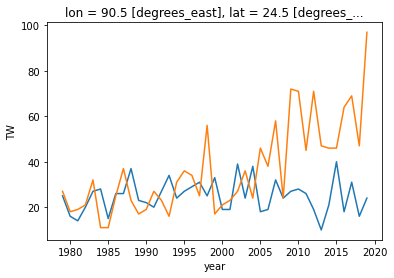

In [104]:
#precip_data_for_coordinate[idx].plot()
#TW_data_for_coordinate[idx_TW].plot()

#precip_years = precip_data_for_coordinate[idx].groupby('time.year').count()
precip_years.plot()
#TW_years = TW_data_for_coordinate[idx_TW].groupby('time.year').count()
TW_years.plot() 

plt.show()
             
#plt.title("Number of Extreme Precipitation Days in Region 2 (90%)")
#plt.xlabel("Year")
#plt.ylabel("Count")
#plt.savefig('/RainHeatData/FinalFigs/extremeTWcounts_R2.png')

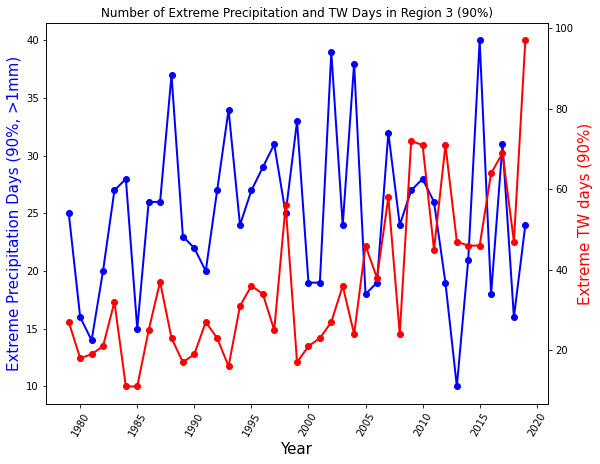

In [106]:
fig, ax = plt.subplots(figsize=[9, 7])

# Plotting the firts line with ax axes
ax.plot(precip_years['year'],
        precip_years,
        color='b', linewidth=2, marker='o')
plt.xticks(rotation=60)
ax.set_xlabel('Year', fontsize=15)
ax.set_ylabel('Extreme Precipitation Days (90%, >1mm)',  color='blue', fontsize=15)

# Create a twin axes ax2 using twinx() function
ax2 = ax.twinx()

# Now, plot the second line with ax2 axes
ax2.plot(TW_years['year'],
         TW_years,
         color='red', linewidth=2, marker='o')

ax2.set_ylabel('Extreme TW days (90%)', color='red', fontsize=15)
plt.title("Number of Extreme Precipitation and TW Days in Region 3 (90%)")
plt.show()
#plt.savefig('/RainHeatData/FinalFigs/extremeTW+Precipcounts_R2.png', dpi=300, bbox_inches='tight')

In [76]:
## Extreme counts for hemisphere ##
total_precip_extreme = list()
total_precip_extreme_counts = list()
total_TW_extreme = list()
significant_mask = np.zeros((precip_data_JJA.shape[1], precip_data_JJA.shape[2]))

for i in range(precip_data_JJA.shape[1]):
    
    for j in range(precip_data_JJA.shape[2]):
        
        TW_data_for_coordinate = TW_data_JJA[:,j,i]
        precip_data_for_coordinate = precip_data_JJA[:,i,j]
        idx = np.squeeze(np.argwhere(np.array(precip_data_for_coordinate) >= raw_percentile_cutoff_JJA[i][j])) #90% of raw precip
        idx_TW = np.squeeze(np.argwhere(np.array(TW_data_for_coordinate) >= raw_percentile_cutoff_TW_JJA[j][i])) # 90% for raw TW
        total_TW_extreme.append(TW_data_for_coordinate[idx_TW]) 
        total_precip_extreme.append(precip_data_for_coordinate[idx])
        #total_precip_extreme_counts = len(list(filter(lambda x: (x >= 0), total_precip_extreme)))
        
        if precip_data_for_coordinate[idx].size > 0: 
            significant_mask[i][j] += 1
        else:
            significant_mask[i][j] = 0

IndexError: index 90 is out of bounds for axis 0 with size 90

Text(0, 0.5, 'Count')

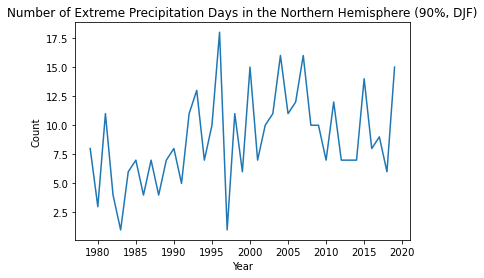

In [78]:
#precip_data_for_coordinate[idx].plot()
#TW_data_for_coordinate[idx_TW].plot()

precip_years = precip_data_for_coordinate[idx].groupby('time.year').count()
precip_years.plot()
plt.title("Number of Extreme Precipitation Days in the Northern Hemisphere (90%, DJF)")
plt.xlabel("Year")
plt.ylabel("Count")
#plt.savefig('/RainHeatData/FinalFigs/90pc_preciprawdata_DJF.png')

In [77]:
#Southwest (30-40N, 110-120W)
#albuquerque: lat=35.5, lon=285.5
#phoenix: lat = 33.5, lon = 292.5

SW= precip_data_JJA.sel(lat='33.5', lon='291.5')
SW_TW= TW_data_JJA.sel(lat='33.5', lon='291.5')

SW_percentile_cutoff_JJA = np.nanpercentile(SW, q=90, axis=0)
SW_TW_percentile_cutoff_JJA = np.nanpercentile(SW_TW, q=90, axis=0)

total_precip_extreme = list()
total_precip_extreme_counts = list()
total_TW_extreme = list()
#significant_mask = np.zeros((alb.shape[1], alb.shape[2]))

#for i in range(SW.shape[1]):
    
 #   for j in range(SW.shape[2]):
         
        TW_data_for_coordinate = SW_TW[:,j,i]
        precip_data_for_coordinate = SW[:,i,j]
        idx = np.squeeze(np.argwhere(np.array(precip_data_for_coordinate) >= SW_percentile_cutoff_JJA[i][j])) #90% of raw precip
        idx_TW = np.squeeze(np.argwhere(np.array(TW_data_for_coordinate) >= SW_TW_percentile_cutoff_JJA[j][i])) # 90% for raw TW
        total_TW_extreme.append(TW_data_for_coordinate[idx_TW]) 
        total_precip_extreme.append(precip_data_for_coordinate[idx])

IndentationError: unexpected indent (1471056723.py, line 20)

In [20]:
#Southwest (30-40N, 110-120W)
#albuquerque: lat=35.5, lon=285.5
#phoenix: lat = 33.5, lon = 291.5
#chihuahua city, mexico: lat= 28.5, lon=286.5
#San Diego: lat=39.5, lon=296.5

#Northeast
#NYC: lat=40, lon = 253
#Montreal: lat=45, lon=253

SW= precip_data_JJA.sel(lat='39.5', lon='296.5')
SW_TW= TW_data_JJA.sel(lat='39.5', lon='296.5')

NE= precip_data_JJA.sel(lat='40.5', lon='253.5')
NE_TW= TW_data_JJA.sel(lat='40.5', lon='253.5')

SW_percentile_cutoff_JJA = np.nanpercentile(SW, q=90, axis=0)
SW_TW_percentile_cutoff_JJA = np.nanpercentile(SW_TW, q=90, axis=0)

NE_percentile_cutoff_JJA = np.nanpercentile(NE, q=90, axis=0)
NE_TW_percentile_cutoff_JJA = np.nanpercentile(NE_TW, q=90, axis=0)

TW_data_for_coordinate = SW_TW
precip_data_for_coordinate = SW
idx = np.squeeze(np.argwhere(np.array(precip_data_for_coordinate) >= SW_percentile_cutoff_JJA)) #90% of raw precip
idx_TW = np.squeeze(np.argwhere(np.array(TW_data_for_coordinate) >= SW_TW_percentile_cutoff_JJA)) # 90% for raw TW

TW_data_for_coordinate_NE = NE_TW
precip_data_for_coordinate_NE = NE
NE_idx = np.squeeze(np.argwhere(np.array(precip_data_for_coordinate_NE) >= NE_percentile_cutoff_JJA)) #90% of raw precip
NE_idx_TW = np.squeeze(np.argwhere(np.array(TW_data_for_coordinate_NE) >= NE_TW_percentile_cutoff_JJA)) # 90% for raw TW

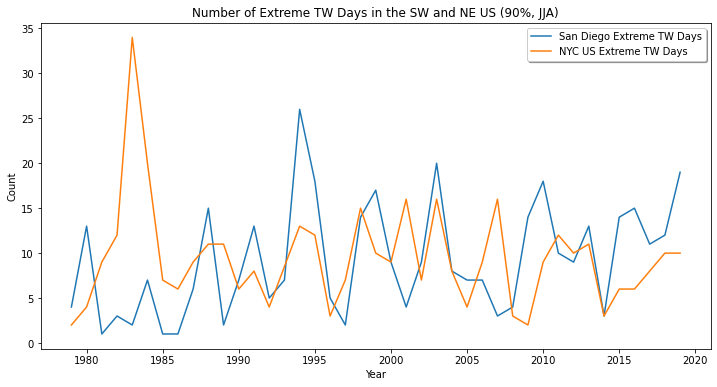

In [21]:
SW_precip_years = precip_data_for_coordinate[idx].groupby('time.year').count()
SW_TW_years = TW_data_for_coordinate[idx_TW].groupby('time.year').count()
NE_precip_years = precip_data_for_coordinate_NE[NE_idx].groupby('time.year').count()
NE_TW_years = TW_data_for_coordinate_NE[NE_idx_TW].groupby('time.year').count()

SW_TW_years.plot(figsize=(12,6))
NE_TW_years.plot()
#precip_years.plot()
plt.title("Number of Extreme TW Days in the SW and NE US (90%, JJA)")
plt.xlabel("Year")
plt.ylabel("Count")
plt.legend(("San Diego Extreme TW Days","NYC US Extreme TW Days"), shadow=True, fancybox=True)

In [61]:
NINO
#average DJF of previous year 

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1870,-1.00,-0.95,-0.83,-0.81,-1.27,-1.08,-1.04,-0.88,-0.53,-0.92,-0.79,-0.79
1,1871,-0.25,-0.58,-0.43,-0.50,-0.70,-0.53,-0.60,-0.33,-0.24,-0.33,-0.31,-0.58
2,1872,-0.72,-0.62,-0.50,-0.77,-0.62,-0.52,-0.32,-0.85,-1.02,-0.94,-0.79,-0.88
3,1873,-0.78,-1.01,-1.31,-0.67,-0.53,-0.48,-0.58,-0.39,-0.34,-0.78,-0.77,-0.70
4,1874,-0.93,-1.06,-1.40,-0.94,-0.86,-0.72,-1.00,-1.05,-1.13,-1.25,-1.33,-1.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,2018,-0.86,-0.73,-0.73,-0.36,-0.12,0.12,0.27,0.05,0.30,0.84,1.00,0.97
149,2019,0.51,0.62,0.81,0.67,0.61,0.66,0.41,0.19,0.11,0.55,0.74,0.51
150,2020,0.64,0.48,0.36,0.49,-0.12,-0.21,-0.04,-0.42,-0.66,-1.19,-1.01,-0.98
151,2021,-1.04,-0.94,-0.72,-0.55,-0.41,-0.06,-0.20,-0.38,-0.50,-0.78,-0.88,-1.07


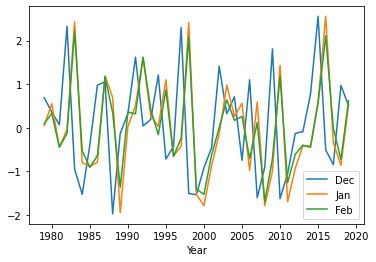

In [58]:
#SW_precip_years.plot()
NINO_DJF.loc['1979':'2019'].plot()
#SW_precip_years
#NINO_Extremes = pd.merge(NINO_DJF,np.array(SW_precip_years))

D:\RainHeatData


<AxesSubplot:xlabel='Year'>

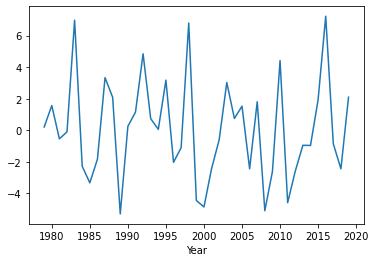

In [24]:
%cd ..
DJF_idx = pd.read_csv('nino34.djf.avg.csv')
DJF_idx = DJF_idx.set_index('Year')
DJF_idx = DJF_idx.DJF.loc['1979':'2019']
DJF_idx.plot()

In [49]:
#remove 1983 to align with extreme precip counts 
# drop the passed labels
DJF_idx2 = DJF_idx.drop(DJF_idx.index[4])
#DJF_idx.drop('1983')
DJF_idx2                       

Year
1979    0.21
1980    1.57
1981   -0.54
1982   -0.10
1984   -2.28
1985   -3.33
1986   -1.83
1987    3.34
1988    2.09
1989   -5.30
1990    0.25
1991    1.15
1992    4.85
1993    0.74
1994    0.06
1995    3.18
1996   -2.03
1997   -1.10
1998    6.80
1999   -4.45
2000   -4.86
2001   -2.43
2002   -0.60
2003    3.03
2004    0.75
2005    1.53
2006   -2.44
2007    1.81
2008   -5.10
2009   -2.61
2010    4.42
2011   -4.59
2012   -2.59
2013   -0.95
2014   -0.96
2015    1.93
2016    7.23
2017   -0.86
2018   -2.44
2019    2.10
Name: DJF, dtype: float64

C:\Users\sojo9\anaconda3\envs\pangeo\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


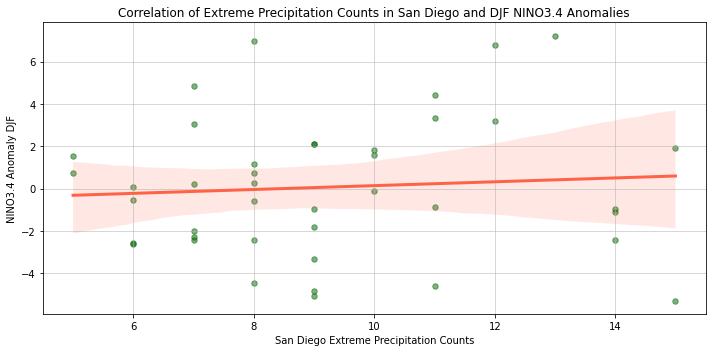

In [79]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 5))
sns.regplot(SW_precip_years, DJF_idx, fit_reg=True,
            scatter_kws={"s": 30, "alpha": 0.5, "color": "darkgreen"},
            line_kws={"linewidth": 3, "color": "tomato"}) 
ax.grid(linewidth=0.5)
ax.set_ylabel('NINO3.4 Anomaly DJF')
ax.set_xlabel('San Diego Extreme Precipitation Counts')
ax.set_title('Correlation of Extreme Precipitation Counts in San Diego and DJF NINO3.4 Anomalies')
#plt.ylim(-2.5, 1.5)
#plt.xlim(-0.4, 0.4)
plt.tight_layout()

In [25]:
>>> import scipy.stats

x=DJF_idx
y=SW_precip_years

matrix = np.corrcoef(x, y)
matrix
scipy.stats.pearsonr(x, y)    # Pearson's r: (correlation coeff, p-value)
#scipy.stats.spearmanr(x, y)   # Spearman's rho
#scipy.stats.kendalltau(x, y)  # Kendall's tau

(0.076541144290586, 0.6343275396320587)

In [28]:
#x.describe -- 41 inputs to array
x_array = np.array(DJF_idx.values.tolist())
x_array

array([ 0.21,  1.57, -0.54, -0.1 ,  6.98, -2.28, -3.33, -1.83,  3.34,
        2.09, -5.3 ,  0.25,  1.15,  4.85,  0.74,  0.06,  3.18, -2.03,
       -1.1 ,  6.8 , -4.45, -4.86, -2.43, -0.6 ,  3.03,  0.75,  1.53,
       -2.44,  1.81, -5.1 , -2.61,  4.42, -4.59, -2.59, -0.95, -0.96,
        1.93,  7.23, -0.86, -2.44,  2.1 ])

In [56]:
import scipy.stats
corr_nino = np.zeros((precip_data_JJA.shape[1], precip_data_JJA.shape[2]))
#x=DJF_idx

#lag = 3
for i in range(precip_data_JJA.shape[1]):
    
    for j in range(precip_data_JJA.shape[2]):
        
        corr_data_for_coordinate = precip_data_JJA[:,i,j]
        percentile_cutoff_JJA = np.nanpercentile(corr_data_for_coordinate, q=90, axis=0)
        idx = np.squeeze(np.argwhere(np.array(corr_data_for_coordinate) >= percentile_cutoff_JJA))
        precip_years = corr_data_for_coordinate[idx].groupby('time.year').count()

In [100]:
import scipy.stats
corr_nino = np.zeros((precip_data_JJA.tp.shape[1], precip_data_JJA.tp.shape[2]))
boolean = np.zeros(precip_data_JJA.tp.shape[0])
#x=DJF_idx

for i in range(precip_data_JJA.tp.shape[1]):
    
    for j in range(precip_data_JJA.tp.shape[2]):
        
        corr_data_for_coordinate = precip_data_JJA.tp[:,i,j]
        percentile_cutoff_JJA = np.nanpercentile(corr_data_for_coordinate, q=90, axis=0)
        idx = np.squeeze(np.argwhere(np.array(corr_data_for_coordinate) >= percentile_cutoff_JJA))
        days_above = corr_data_for_coordinate.where(corr_data_for_coordinate >= percentile_cutoff_JJA)
        boolean[idx] = 1
        boolean[~idx] = 0
        data_xr = xr.DataArray(boolean, 
        coords={'time': corr_data_for_coordinate.time}, 
        dims=[ "time"])
        precip_years = data_xr.groupby('time.year').sum()
       
        #precip_years = corr_data_for_coordinate[idx].groupby('time.year').count()
        precip_counts = np.array(precip_years.values.tolist())
        corr =np.array(scipy.stats.pearsonr(x_array, precip_counts))
              
        corr_nino[i][j] = corr[0]

In [117]:
from matplotlib import colors
# set the colormap and centre the colorbar
class MidpointNormalize(colors.Normalize):
    "Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value) e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))"
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)
    def __call__(self, value, clip=None):
        # I’m ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

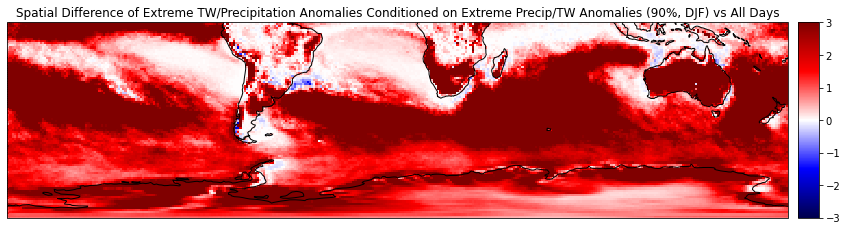

In [64]:
fig= plt.figure(figsize=(14,6))
ax = plt.axes(projection=ccrs.PlateCarree())
cm = plt.cm.get_cmap('coolwarm')
res = '110m'
ax.add_feature(cfeature.COASTLINE.with_scale(res))
#gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
 #                 linewidth=1, color='gray', alpha=0.5, linestyle='--', zorder=10)
# Set mid value at 0 (where color bar sets to white)
#mid_val = 0
#divnorm = MidpointNormalize(midpoint=mid_val,vmin=-2, vmax=20)
sc = plt.pcolormesh(daily_precip_regrid.lon.values[lons[:,0]], daily_precip_regrid.lat.values[lats[:,0]], stand,transform=ccrs.PlateCarree(), cmap='seismic') #coolwarm, BrBG
#norm=divnorm
#plt.pcolormesh(yearly_precip_regridded.lon.values[lons[:,0]], yearly_precip_regridded.lat.values[lats[:,0]], np.ma.masked_less(significant_mask, 0), facecolor = 'None', edgecolors = None)
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
ax.set_title('Spatial Difference of Extreme TW/Precipitation Anomalies Conditioned on Extreme Precip/TW Anomalies (90%, DJF) vs All Days')
#Difference in Mean Extreme Wet Bulb Temperature Anomaly on Extreme Precipitation Anomaly Days
#Difference in Mean Extreme Precipitation Anomaly on Extreme Wet Bulb Temperature Anomaly Days
plt.colorbar(sc, cax=cax) # Similar to fig.colorbar(im, cax = cax)
plt.clim(-3,3)
#-2.5-2 for TW, -4-4 for Precip
#plt.savefig('/RainHeatData/Figures/spatialcorrelation_DJF_-3+3scale.png')
plt.show()

## lead/lag plots: +/- 2 degrees
* albuquerque: lat=35.5, lon=285.5
* phoenix: lat = 33.5, lon = 291.5
* chihuahua city, mexico: lat= 28.5, lon=286.5
* San Diego: lat=32.5, lon=296.5
* Seattle: lat=47, lon=122W/302E
* Tokyo: lat=35.5, lon=139E
* Timbuktu (Sahel region): lat=16, lon=3W
* Dhaka: lat=23.5, lon=90E
* NYC: lat=40, lon = 253
* Montreal: lat=45, lon=253
* Des Moines, Iowa: lat=41, lon=93W/273E
* Milan, Italy: lat=45N, lon=9E
### Japan
* Kumagaya Japan: lat = 36N, lon=139E
* Kagoshima Japan: lat=31N, lon=130E
* Sapporo Japan: lat=43N, lon=141E
* Hiroshima: lat=34 , lon=132
### India
* Calcutta India: lat=22N, 88E
* New Delhi: lat=28N, lon=77E
* Mumbai: lat=19, lon=72E
### Australia
* Melbourne (SE): lat=37S, lon=144E
* Perth (SW): lat=31S, lon=115E
* Darwin (N): lat=12S, lon=130

In [63]:
#ERA5 Northern Hemisphere
lats = np.argwhere((yearly_precip_regridded.lat.values >= 0) & (yearly_precip_regridded.lat.values <= 90))
lons = np.argwhere((yearly_precip_regridded.lon.values >= 0) & (yearly_precip_regridded.lon.values <= 360))
precip_data_N = yearly_precip_regridded.sel(lon = slice(0,360), lat=slice(0,90)) #yearly_precip_regridded
TW_data_N = all_tw_regridded.sel(lon = slice(0,360), lat=slice(0,90))
temp_data_N = temp_dailymean.sel(lon = slice(0,360), lat=slice(0,90))

#Southern Hemisphere
#lats = np.argwhere((yearly_precip_regridded.lat.values >= -90) & (yearly_precip_regridded.lat.values <= 0))
#lons = np.argwhere((yearly_precip_regridded.lon.values >= 0) & (yearly_precip_regridded.lon.values <= 360))
#precip_data_S = yearly_precip_regridded.sel(lon = slice(0,360), lat=slice(-90,0)) #yearly_precip_regridded
#TW_data_S = all_tw_regridded.sel(lon = slice(0,360), lat=slice(-90,0))
#temp_data = temp_dailymean.sel(lon = slice(0,360), lat=slice(-90,0))

In [61]:
june_months = np.argwhere((yearly_precip_regridded.time.values.astype('datetime64[M]').astype(int) % 12 + 1) == 6)
july_months = np.argwhere((yearly_precip_regridded.time.values.astype('datetime64[M]').astype(int) % 12 + 1) == 7)
august_months = np.argwhere((yearly_precip_regridded.time.values.astype('datetime64[M]').astype(int) % 12 + 1) == 8)
JJA_idx = np.concatenate([june_months, july_months, august_months])
JJA_idx

december_months = np.argwhere((yearly_precip_regridded.time.values.astype('datetime64[M]').astype(int) % 12 + 1) == 12)
january_months = np.argwhere((yearly_precip_regridded.time.values.astype('datetime64[M]').astype(int) % 12 + 1) == 1)
february_months = np.argwhere((yearly_precip_regridded.time.values.astype('datetime64[M]').astype(int) % 12 + 1) == 2)
DJF_idx = np.concatenate([december_months, january_months, february_months])

In [110]:
#Sapporo coordinates
lats = np.argwhere((yearly_precip_regridded.lat.values >= 41.5) & (yearly_precip_regridded.lat.values <= 45.5))
lons = np.argwhere((yearly_precip_regridded.lon.values >= 139.5) & (yearly_precip_regridded.lon.values <= 143.5))

In [18]:
TW_data_2018 = TW_data_N.sel(time = slice('2018-06-01T00:00:00.000000000','2018-08-31T00:00:00.000000000'))
precip_data_2018 = precip_data_N.sel(time = slice('2018-06-01T00:00:00.000000000','2018-08-31T00:00:00.000000000'))
#TW_data_2018

<xarray.Dataset>
Dimensions:    (time: 92, bnds: 2, lon: 360, lat: 90)
Coordinates:
  * time       (time) datetime64[ns] 2018-06-01 2018-06-02 ... 2018-08-31
  * lon        (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lat        (lat) float64 0.5 1.5 2.5 3.5 4.5 ... 85.5 86.5 87.5 88.5 89.5
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 2018-06-01 2018-06-01 ... 2018-08-31
    TW         (time, lon, lat) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.9rc1 (https://mpimet.mpg...
    Conventions:  CF-1.6
    history:      Fri Dec 03 16:36:21 2021: cdo mergetime TW_daily_max_1979_d...
    frequency:    day
    CDO:          Climate Data Operators version 1.9.9rc1 (https://mpimet.mpg...

In [29]:
#*Hiroshima
kumagaya_era = precip_data_N.sel(lat='34.5', lon='132.5')
kumagaya_precip = kumagaya_era.sel(time = slice('2018-06-01T00:00:00.000000000','2018-08-31T00:00:00.000000000'))
kumagaya_tw = TW_data_N.sel(lat='34.5', lon='132.5')
kumagaya_TW = kumagaya_tw.sel(time = slice('2018-06-01T00:00:00.000000000','2018-08-31T00:00:00.000000000')).TW
#alb_era_monthly = alb_era.groupby('time.dayofyear').mean(dim='time')
#alb_era_anom = alb_era.groupby('time.dayofyear') - alb_era_monthly

numbers_series = pd.Series(kumagaya_precip)
TW_series = pd.Series(kumagaya_TW)
#numbers_series.plot()
#TW_series.plot()

In [30]:
mean_TW = np.mean(TW_series)
mean_precip = np.mean(numbers_series)

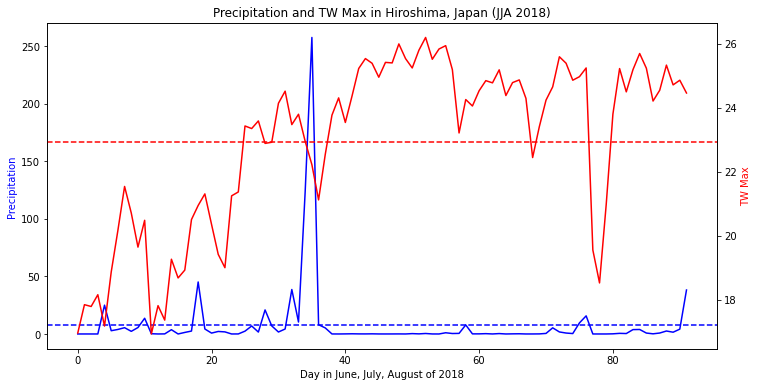

<Figure size 432x288 with 0 Axes>

In [32]:
    fig, ax1 = plt.subplots(figsize=(12,6))
    ax2 = ax1.twinx()
    #plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m')) #%Y--%d
    #plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
    ax1.plot(numbers_series, 'b-')
    ax1.axhline(mean_precip, color="b",linestyle='dashed')
    ax2.plot(TW_series, 'r-')
    ax2.axhline(mean_TW, color="r",linestyle='dashed')
    #ax2.axhline(precip_data.time.values[JJA_idx][:,0][days], mean_TW, 'r-')
    #plt.gcf().autofmt_xdate()
    ax1.set_xlabel('Day in June, July, August of 2018')
    ax1.set_ylabel('Precipitation', color='b')
    ax2.set_ylabel('TW Max', color='r')
    plt.title('Precipitation and TW Max in Hiroshima, Japan (JJA 2018)')
    plt.show()
#plt.savefig('/RainHeatData/Figures/HiroshimaprecipTWJJA2018.png')

In [111]:
precip_data_JJA = precip_data_N.where(precip_data_N.time.dt.month.isin([6,7,8]),drop=True) #tp for ERA5, precip for NOAA
TW_data_JJA = TW_data_N.where(TW_data_N.time.dt.month.isin([6,7,8]),drop=True).TW
temp_data_JJA = temp_data_N.where(temp_data.time.dt.month.isin([6,7,8]),drop=True).t2m
#temp_data
#precip_data_JJA

In [112]:
precip_data = precip_data_JJA.values[:,lats[0,0]:lats[-1,0],lons[0,0]:lons[-1,0]]
TW_data = TW_data_JJA.values[:,lons[0,0]:lons[-1,0], lats[0,0]:lats[-1,0],]
temp_data = temp_data_JJA.values[:,lats[0,0]:lats[-1,0],lons[0,0]:lons[-1,0]]

precip_data

array([], shape=(3772, 0, 4), dtype=float32)

In [113]:
precip_data = precip_data_JJA.sel(lon = slice(139.5,143.5), lat=slice(41.5,45.5))
TW_data = TW_data_JJA.sel(lon = slice(139.5,143.5), lat=slice(41.5,45.5))
temp_data = temp_data_JJA.sel(lon = slice(139.5,143.5), lat=slice(41.5,45.5))
#precip_data

In [114]:
#daily average
precip_mean = precip_data.groupby('time.dayofyear').mean(dim='time')
#30 day rolling mean
precip_rolling = precip_data.rolling(time = 30, center = True).mean('time')
#anomaly
precip_data = precip_data.groupby('time.dayofyear') - precip_rolling.groupby('time.dayofyear').mean(dim='time')

#daily average
TW_mean = TW_data.groupby('time.dayofyear').mean(dim='time')
#rolling mean
TW_rolling = TW_data.rolling(time = 30, center = True).mean('time')

#anomalies -- with 5 day smoothed climatology and without
TW_data = TW_data.groupby('time.dayofyear') - TW_rolling.groupby('time.dayofyear').mean(dim='time')

In [115]:
#daily average
temp_mean = temp_data.groupby('time.dayofyear').mean(dim='time')
#rolling mean
temp_rolling = temp_data.rolling(time = 30, center = True).mean('time')

#anomalies -- with 5 day smoothed climatology and without
temp_data = temp_data.groupby('time.dayofyear') - temp_rolling.groupby('time.dayofyear').mean(dim='time')

In [116]:
june_months = np.argwhere((precip_data.time.values.astype('datetime64[M]').astype(int) % 12 + 1) == 6)
july_months = np.argwhere((precip_data.time.values.astype('datetime64[M]').astype(int) % 12 + 1) == 7)
august_months = np.argwhere((precip_data.time.values.astype('datetime64[M]').astype(int) % 12 + 1) == 8)
JJA_idx = np.concatenate([june_months, july_months, august_months])
JJA_idx

december_months = np.argwhere((precip_data.time.values.astype('datetime64[M]').astype(int) % 12 + 1) == 12)
january_months = np.argwhere((precip_data.time.values.astype('datetime64[M]').astype(int) % 12 + 1) == 1)
february_months = np.argwhere((precip_data.time.values.astype('datetime64[M]').astype(int) % 12 + 1) == 2)
DJF_idx = np.concatenate([december_months, january_months, february_months])

In [77]:
#albuquerque: lat=35.5, lon=285.5
#phoenix: lat = 33.5, lon = 291.5
#chihuahua city, mexico: lat= 28.5, lon=286.5
#San Diego: lat=39.5, lon=296.5
#Seattle:
#Tokyo: lat=35.5, lon=139E
#Mumbai:
#Dhaka:
#NYC: lat=40, lon = 253
#Montreal: lat=45, lon=253

Tokyo= precip_data_JJA.sel(lat='35.5', lon='139.5')
Tokyo_TW= TW_data_JJA.sel(lat='35.5', lon='139.5')

#NE= precip_data_JJA.sel(lat='40.5', lon='253.5')
#NE_TW= TW_data_JJA.sel(lat='40.5', lon='253.5')

percentile_cutoff_JJA = np.nanpercentile(Tokyo, q=90, axis=0)
TW_percentile_cutoff_JJA = np.nanpercentile(Tokyo_TW, q=90, axis=0)

#NE_percentile_cutoff_JJA = np.nanpercentile(NE, q=90, axis=0)
#NE_TW_percentile_cutoff_JJA = np.nanpercentile(NE_TW, q=90, axis=0)

In [118]:
raw_percentile_cutoff_JJA = np.zeros((precip_data.shape[1], precip_data.shape[2]))
rain_threshold = 0
for i in range(precip_data.shape[1]):
    
    for j in range(precip_data.shape[2]):
        
        precip_data_for_coordinate = precip_data[:,i,j]
        #idx_norain = np.squeeze(np.argwhere(np.array(precip_data_for_coordinate) <= rain_threshold))
        idx_rain = np.squeeze(np.argwhere(np.array(precip_data_for_coordinate) > rain_threshold))
        precip_data_JJA_pc = precip_data_for_coordinate[idx_rain]
        
        raw_percentile_cutoff_JJA[i][j] = np.nanpercentile(precip_data_JJA_pc, q=90)

In [119]:
max_percentile_idx = np.unravel_index(raw_percentile_cutoff_JJA.argmax(), raw_percentile_cutoff_JJA.shape)
max_cutoff = raw_percentile_cutoff_JJA[max_percentile_idx]
max_percentile_idx

(1, 2)

In [120]:
max_temp_idx = np.unravel_index(TW_percentile_cutoff_JJA.argmax(), TW_percentile_cutoff_JJA.shape)
max_drytemp_idx = np.unravel_index(temp_percentile_cutoff_JJA.argmax(), temp_percentile_cutoff_JJA.shape)

In [121]:
TW_percentile_cutoff_JJA[max_temp_idx]

3.6113619804382324

In [122]:
temp_percentile_cutoff_JJA[max_temp_idx]

2.9017242431640624

In [123]:
max_raw_data_precip = precip_data[:,max_percentile_idx[0],max_percentile_idx[1]]
max_raw_data_TW = TW_data[:, max_percentile_idx[1], max_percentile_idx[0]]
max_raw_data_temp = temp_data[:,max_percentile_idx[0],max_percentile_idx[1]]

In [124]:
mean_TW = np.mean(TW_data)
mean_temp = np.mean(temp_data)
#mean_TW

In [126]:
def plot(event, lead=5, lag=5):
    
    event_day = precip_data.time.values[JJA_idx][:,0][event] #yearly_precip
    start = event_day - np.timedelta64(lag, 'D')
    end = event_day + np.timedelta64(lead, 'D')
    days = np.argwhere((precip_data.time.values[JJA_idx][:,0] >= start) & (precip_data.time.values[JJA_idx][:,0] <= end))
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
    ax1.plot(precip_data.time.values[JJA_idx][:,0][days], max_raw_data_precip[days], 'b-')
    ax2.plot(precip_data.time.values[JJA_idx][:,0][days], max_raw_data_TW[days], 'r-')
    ax2.plot(precip_data.time.values[JJA_idx][:,0][days], max_raw_data_temp[days], 'g-')
    ax2.axhline(precip_data.time.values[JJA_idx][:,0][days], mean_TW, 'r-')
    plt.gcf().autofmt_xdate()
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Precipitation', color='b')
    ax2.set_ylabel('TW Max', color='r')
    plt.show()

In [127]:
def combined_plot(idx=max_percentile_idx, lead=5, lag=5, show=True):
    
    raw_data_precip = np.array(precip_data[:,idx[0],idx[1]])
    raw_data_TW = np.array(TW_data[:, idx[1], idx[0]]) #
    raw_data_temp = temp_data[:, idx[0], idx[1]]
    percentile_cutoff = percentile_cutoff_JJA[idx]
    extreme_events = np.squeeze(np.argwhere(np.array(raw_data_precip) >= percentile_cutoff))
    extreme_events = extreme_events[extreme_events<=3761]
    total_TW = list()
    total_precip = list()
    total_t2m = list()
    
    for event in extreme_events:
        
        event_day = precip_data.time.values[JJA_idx][:,0][event] #select every extreme day at precip index grid point, yearly_precip_regridded
        start = event_day - np.timedelta64(lag, 'D') #5 days before day of precip
        end = event_day + np.timedelta64(lead, 'D') #5 days after
        days_before = np.argwhere((precip_data.time.values[JJA_idx][:,0] >= start) & (precip_data.time.values[JJA_idx][:,0] <= event_day))
        days_before = days_before[days_before<=3761]
        days_after = np.argwhere((precip_data.time.values[JJA_idx][:,0] > event_day) & (precip_data.time.values[JJA_idx][:,0] <= end))
        days_after = days_after[days_after<=3760]
        #for if the lead and lag days are different
        total_TW.append(np.concatenate((np.pad(raw_data_TW[days_before].ravel(), (lag - len(days_before) + 1, 0), 'constant', constant_values=(np.nan,)), np.pad(raw_data_TW[days_after].ravel(), (0, lead - len(days_after)), mode='constant', constant_values=(np.nan,)))))
        total_precip.append(np.concatenate((np.pad(raw_data_precip[days_before].ravel(), (lag - len(days_before) + 1, 0), 'constant', constant_values=(np.nan,)), np.pad(raw_data_precip[days_after].ravel(), (0, lead - len(days_after)), 'constant', constant_values=(np.nan,)))))
        total_t2m.append(np.concatenate((np.pad(raw_data_temp[days_before].values.ravel(), (lag - len(days_before) + 1, 0), 'constant', constant_values=(np.nan,)), np.pad(raw_data_temp[days_after].values.ravel(), (0, lead - len(days_after)), 'constant', constant_values=(np.nan,)))))

        tw_array = np.array(total_TW)
        precip_array = np.array(total_precip)
        t2m_array = np.array(total_t2m)
    
    if show:
        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
        ax1.plot(np.nanmean(precip_array, axis=0), 'b-')
        ax2.plot(np.nanmean(tw_array, axis=0), 'r-')
        ax2.axhline(mean_TW, color="r", linestyle='dashed')
        ax2.axhline(mean_temp, color="b", linestyle='dashed')
        ax2.plot(np.nanmean(t2m_array, axis=0), 'g-')
        plt.gcf().autofmt_xdate()
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Precipitation Anomaly', color='b')
        ax2.set_ylabel('Max Temp Anomaly', color='r')
        plt.title('Sapporo, Japan Lead/Lag of Precipitation and TW Anomalies')
        #plt.legend("Precipitation", "TW Max", "2mTemp")
        plt.show()
    
    return np.nanmean(precip_array, axis=0), np.nanmean(tw_array, axis=0), np.nanmean(t2m_array, axis=0)        

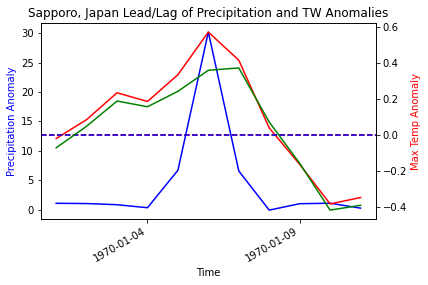

<Figure size 432x288 with 0 Axes>

In [129]:
combined_plot(lead=5, lag=5)
#plt.savefig('/RainHeatData/Figures/Sapporo_leadlaganom_t2m.png')

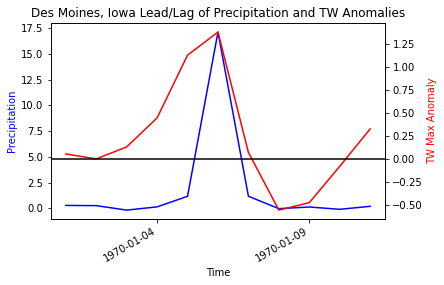

(array([ 0.28095108,  0.262093  , -0.17354049,  0.14112926,  1.1680146 ,
        17.107544  ,  1.1712095 , -0.03069526,  0.12961252, -0.09531393,
         0.19405651], dtype=float32),
 array([ 5.3662661e-02, -1.6939201e-04,  1.2998150e-01,  4.4556421e-01,
         1.1263367e+00,  1.3770643e+00,  7.0636839e-02, -5.5595016e-01,
        -4.7520015e-01, -8.0797404e-02,  3.2566625e-01], dtype=float32))

In [53]:
combined_plot(max_temp_idx)

In [52]:
#precip_data
hiro_precip = precip_data_N.sel(lat='34.5', lon='132.5')
hiro_tw = TW_data_N.sel(lat='34.5', lon='132.5')

In [62]:
### scatter plot in T-q space of all days in heat season for each location (JJA or DJF) 
### color code points based on whether they have precip leading heat or heat leading precip
lats = np.argwhere((precip_data_N.lat.values >= 33.5) & (precip_data_N.lat.values <= 35.5))
lons = np.argwhere((precip_data_N.lon.values >= 133.5) & (precip_data_N.lon.values <= 131.5))

#precip_data_JJA = precip_data_N.values[JJA_idx[:,0],lats[0,0]:lats[-1,0],lons[0,0]:lons[-1,0]]
#TW_data_JJA = TW_data_N.TW.values[JJA_idx[:,0],lons[0,0]:lons[-1,0], lats[0,0]:lats[-1,0],]

precip_data_JJA = hiro_precip.where(hiro_precip.time.dt.month.isin([6,7,8]),drop=True) #tp for ERA5, precip for NOAA
TW_data_JJA = hiro_tw.where(hiro_tw.time.dt.month.isin([6,7,8]),drop=True).TW

#percentile_cutoff_JJA = np.nanpercentile(precip_data_JJA, q=90, axis=0)

#precip_raveled = precip_data_JJA.ravel()
#tw_raveled = TW_data_JJA.ravel() 

extreme_precip_cutoff = np.nanpercentile(precip_raveled[precip_raveled > 0], q=90)
extreme_TW_cutoff = np.nanpercentile(tw_raveled[tw_raveled > 0], q=90)

AttributeError: 'DataArray' object has no attribute 'ravel'

In [65]:
extreme_precip_cutoff = np.nanpercentile(precip_data_JJA[precip_data_JJA > 0], q=90)
extreme_TW_cutoff = np.nanpercentile(TW_data_JJA[TW_data_JJA > 0], q=90)

In [68]:
precip_data_JJA = precip_data_JJA.sel(time = slice('1979-01-01T00:00:00.000000000','2019-12-21T00:00:00.000000000'))
TW_data_JJA = TW_data_JJA.sel(time = slice('1979-01-01T00:00:00.000000000','2019-12-21T00:00:00.000000000'))

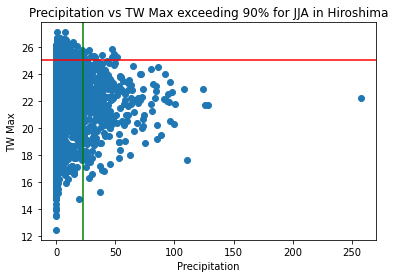

In [72]:
plt.scatter(precip_data_JJA, TW_data_JJA)
plt.axvline(x=extreme_precip_cutoff, color='g')
plt.axhline(extreme_TW_cutoff, color='r')
plt.xlabel('Precipitation')
plt.ylabel('TW Max')
plt.title('Precipitation vs TW Max exceeding 90% for JJA in Hiroshima')
plt.show()

# misc

In [85]:
#Mumbai
SE_lats = np.argwhere((precip_data_N.lat.values >= 22) & (precip_data_N.lat.values <= 24))
SE_lons = np.argwhere((precip_data_N.lon.values >= 89) & (precip_data_N.lon.values <= 91))

In [86]:
SE_US_precip_data_JJA = precip_data_N.values[JJA_idx[:,0],SE_lats[0,0]:SE_lats[-1,0],SE_lons[0,0]:SE_lons[-1,0]]
SE_US_TW_data_JJA = TW_data_N.TW.values[JJA_idx[:,0],SE_lons[0,0]:SE_lons[-1,0], SE_lats[0,0]:SE_lats[-1,0],]
percentile_cutoff_SE_JJA = np.nanpercentile(SE_US_precip_data_JJA, q=90, axis=0)

In [87]:
precip_raveled = SE_US_precip_data_JJA.ravel()
tw_raveled = SE_US_TW_data_JJA.ravel() 

In [88]:
extreme_precip_cutoff = np.nanpercentile(precip_raveled[precip_raveled > 0], q=90)

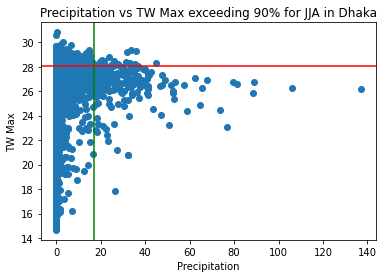

<Figure size 432x288 with 0 Axes>

In [90]:
plt.scatter(precip_raveled[precip_raveled > 0], tw_raveled[precip_raveled > 0])
plt.axvline(x=extreme_precip_cutoff, color='g')
plt.axhline(np.nanpercentile(tw_raveled, q=90), color='r')
plt.xlabel('Precipitation')
plt.ylabel('TW Max')
plt.title('Precipitation vs TW Max exceeding 90% for JJA in Dhaka')
plt.show()
#plt.savefig('/RainHeatData/Figures/DhakaPrecipTWJJAScatter.png')

In [91]:
year_list = np.unique(precip_data_N.time.values.astype('datetime64[Y]'))

In [111]:
def get_annual_pct(array, x, y, q=90, returnYear=False):
    
    result = list()
    years = list()
    for year in year_list:
        
        #idx = np.argwhere(yearly_precip.time.values[JJA_idx].astype('datetime64[Y]') == year)
        idx = np.argwhere(yearly_precip_regridded.time.values.astype('datetime64[Y]') == year)
        res = np.nanpercentile(array[idx,x,y], q=q)
        if np.isnan(res):
            print(array[idx,x,y])
        result.append(res)
        years.append(year.astype(int))
    
    if returnYear:
        
        return np.array(result), np.array(years)
    
    return np.array(result)
def get_year_trend_line(array,x,y,q=90,show=False):
    
    res, years = get_annual_pct(array,x,y,q=q,returnYear=True)
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(years, res)
    
    if show:
        
        plt.scatter(years, res)
        plt.plot(years, years*slope + intercept)
        plt.show()
        
    return slope
    
def get_trend_line(x,y,q=90,show=False):
    
    tw_annual_pct = get_annual_pct(new_tw, x, y, q)
    precip_annual_pct = get_annual_pct(new_precip, x, y, q)
    slope, intercept, r_value, p_value, std_err = stats.linregress(precip_annual_pct,tw_annual_pct)

    if show:
        
        plt.scatter(precip_annual_pct, tw_annual_pct)
        plt.plot(precip_annual_pct, precip_annual_pct*slope + intercept)
        plt.show()
        
    return slope
def get_trend_array(array,q=90):
    
    
    result_array = np.zeros((array[0].shape))
    
    for i in tqdm(range(result_array.shape[0])):
        for j in range(result_array.shape[1]):

            result_array[i][j] = get_year_trend_line(array,i,j,q=q)
            
    return result_array

In [66]:
#midwest USA coordinates = 45-55, 255-265
#tokyo: 35-45, 135-145
#australia: -20 - -30N, 120-150E
SE_lats = np.argwhere((yearly_precip_regridded.lat.values >= 38) & (yearly_precip_regridded.lat.values <= 42))
SE_lons = np.argwhere((yearly_precip_regridded.lon.values >= 138) & (yearly_precip_regridded.lon.values <= 142))

SW_lats = np.argwhere((yearly_precip_regridded.lat.values >= 38) & (yearly_precip_regridded.lat.values <= 42))
SW_lons = np.argwhere((yearly_precip_regridded.lon.values >= 138) & (yearly_precip_regridded.lon.values <= 142))

In [127]:
US_precip_data = yearly_precip_regridded.sel(lon = slice(135,145), lat=slice(35,45),time = slice('1979-01-01T00:00:00.000000000','2019-12-21T00:00:00.000000000'))
US_TW_data = all_tw_regridded.sel(lon = slice(135,145), lat=slice(35,45),time = slice('1979-01-01T00:00:00.000000000','2019-12-21T00:00:00.000000000'))
US_t2m_data = temp_dailymean.sel(lon = slice(135,145), lat=slice(35,45),time = slice('1979-01-01T00:00:00.000000000','2019-12-21T00:00:00.000000000'))

#SE_US_precip_data_JJA = yearly_precip_regridded.tp.values[JJA_idx[:,0],SE_lats[0,0]:SE_lats[-1,0],SE_lons[0,0]:SE_lons[-1,0]]
#SE_US_TW_data_JJA = all_tw_regridded.TW.values[JJA_idx[:,0],SE_lons[0,0]:SE_lons[-1,0], SE_lats[0,0]:SE_lats[-1,0],]
#percentile_cutoff_SE_JJA = np.nanpercentile(SE_US_precip_data_JJA, q=90, axis=0)

#JJA
SE_US_precip_data_JJA = yearly_precip_regridded.where(yearly_precip_regridded.time.dt.month.isin([6,7,8]),drop=True).tp
#yearly_precip_regridded.tp.values[JJA_idx[:,0],SE_lats[-1,0]:SE_lats[0,0],SE_lons[0,0]:SE_lons[-1,0]]

SE_US_TW_data_JJA = all_tw_regridded.where(all_tw_regridded.time.dt.month.isin([6,7,8]),drop=True).TW
#all_tw_regridded.TW.values[JJA_idx[:,0],SE_lons[0,0]:SE_lons[-1,0], SE_lats[-1,0]:SE_lats[0,0],]

t2m_data_JJA = temp_dailymean.where(temp_dailymean.time.dt.month.isin([6,7,8]),drop=True).t2m
#temp_dailymean.t2m.values[JJA_idx[:,0],SE_lats[-1,0]:SE_lats[0,0],SE_lons[0,0]:SE_lons[-1,0]]

In [46]:
#data for calculating anomalies
#cut TW time so data are the same
TW_data = US_TW_data.sel(time = slice('1979-01-01T00:00:00.000000000','2019-12-21T00:00:00.000000000'))
precip_data = US_precip_data.sel(time = slice('1979-01-01T00:00:00.000000000','2019-12-21T00:00:00.000000000'))
t2m_data = US_t2m_data.sel(time = slice('1979-01-01T00:00:00.000000000','2019-12-21T00:00:00.000000000'))

#select DJF months - summer for Southern Hem
precip_data_JJA = precip_data.where(precip_data.time.dt.month.isin([12,1,2]),drop=True).tp #tp for ERA5
TW_data_JJA = TW_data.where(TW_data.time.dt.month.isin([12,1,2]),drop=True).TW
#t2m_data_JJA = 

In [14]:
#percentile_cutoff_SW_JJA = np.nanpercentile(SW_US_precip_data_JJA, q=90, axis=0)
#percentile_cutoff_TW_SW_JJA = np.nanpercentile(SW_US_TW_data_JJA, q=90, axis=0)
#percentile_cutoff_t2m_SW_JJA = np.nanpercentile(SW_US_t2m_data_JJA, q=90, axis=0)

max_percentile_idx = np.unravel_index(percentile_cutoff_JJA.argmax(), percentile_cutoff_JJA.shape)
max_cutoff = percentile_cutoff_JJA[max_percentile_idx]

max_temp_idx = np.unravel_index(TW_percentile_cutoff_JJA.argmax(), TW_percentile_cutoff_JJA.shape)

TW_percentile_cutoff_JJA[max_temp_idx]
percentile_cutoff_t2m_SW_JJA[max_temp_idx]

289.14649658203126

In [15]:
max_raw_data_precip = SW_US_precip_data_JJA[:,max_percentile_idx[0],max_percentile_idx[1]]
max_raw_data_TW = SW_US_TW_data_JJA[:, max_percentile_idx[1], max_percentile_idx[0]]
max_raw_data_TW = SW_US_t2m_data_JJA[:, max_percentile_idx[0], max_percentile_idx[1]]

In [14]:
####Precip and TW 5 day rolling anomalies####

#5 day rolling mean precipitation
precip_rolling = SE_US_precip_data_JJA.rolling(time = 5, center = True).mean('time')
#anomaly
precip_data_anom = SE_US_precip_data_JJA.groupby('time.dayofyear') - precip_rolling.groupby('time.dayofyear').mean(dim='time') 

#5 day rolling mean TW
TW_rolling = SE_US_TW_data_JJA.rolling(time = 5, center = True).mean('time')
#anomaly
TW_data_anom = SE_US_TW_data_JJA.groupby('time.dayofyear') - TW_rolling.groupby('time.dayofyear').mean(dim='time')

#5 day rolling mean dry bulb temp
t2m_rolling = t2m_data_JJA.rolling(time = 5, center = True).mean('time')
#anomaly
t2m_data_anom = t2m_data_JJA.groupby('time.dayofyear') - t2m_rolling.groupby('time.dayofyear').mean(dim='time')

In [58]:
#SE_US_precip_anom_JJA = US_precip_data_anom.sel(lon = slice(240,285), lat=slice(40,20))
#SE_US_TW_anom_JJA = US_TW_anom_JJA.sel(lon = slice(240,285), lat=slice(40,20))
#SE_US_TW_anom_JJA.mean('time').plot()

In [128]:
#percentile_cutoff_SE_JJA = np.nanpercentile(SE_US_precip_data_JJA, q=90, axis=0)
percentile_cutoff_SE_JJA = np.nanpercentile(SE_US_precip_data_JJA, q=90, axis=0)
percentile_cutoff_TW_SE_JJA = np.nanpercentile(SE_US_TW_data_JJA, q=90, axis=0)
percentile_cutoff_t2m_JJA = np.nanpercentile(t2m_data_JJA, q=90, axis=0)

In [129]:
max_percentile_idx = np.unravel_index(percentile_cutoff_SE_JJA.argmax(), percentile_cutoff_SE_JJA.shape)
max_cutoff = percentile_cutoff_SE_JJA[max_percentile_idx]

In [130]:
max_temp_idx = np.unravel_index(percentile_cutoff_TW_SE_JJA.argmax(), percentile_cutoff_TW_SE_JJA.shape)
max_t2m_idx = np.unravel_index(percentile_cutoff_t2m_JJA.argmax(), percentile_cutoff_t2m_JJA.shape)

In [131]:
percentile_cutoff_TW_SE_JJA[max_temp_idx]
#TW 5 day rolling anomaly

30.695038032531738

In [132]:
percentile_cutoff_t2m_JJA[max_t2m_idx]

314.6129577636719

In [133]:
#condition variables on extreme precip days
max_raw_data_precip = SE_US_precip_data_JJA[:,max_percentile_idx[0],max_percentile_idx[1]]
max_raw_data_TW = SE_US_TW_data_JJA[:, max_percentile_idx[1], max_percentile_idx[0]]
max_raw_data_t2m = t2m_data_JJA[:, max_percentile_idx[0],max_percentile_idx[1]]

In [134]:
def plot(event, lead=5, lag=5):
    
    event_day = yearly_precip.time.values[JJA_idx][:,0][event]
    start = event_day - np.timedelta64(lag, 'D')
    end = event_day + np.timedelta64(lead, 'D')
    days = np.argwhere((yearly_precip.time.values[JJA_idx][:,0] >= start) & (yearly_precip.time.values[JJA_idx][:,0] <= end))
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
    ax1.plot(yearly_precip.time.values[JJA_idx][:,0][days], max_raw_data_precip[days], 'g-')
    ax2.plot(yearly_precip.time.values[JJA_idx][:,0][days], max_raw_data_TW[days], 'b-')
    plt.gcf().autofmt_xdate()
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Precipitation', color='g')
    ax2.set_ylabel('TW Max', color='b')
    plt.show()

In [116]:
def plot(event, lead=5, lag=5):
    
    event_day = yearly_precip_regridded.time.values[JJA_idx][:,0][event]
    start = event_day - np.timedelta64(lag, 'D')
    end = event_day + np.timedelta64(lead, 'D')
    days = np.argwhere((yearly_precip_regridded.time.values[JJA_idx][:,0] >= start) & (yearly_precip_regridded.time.values[JJA_idx][:,0] <= end))
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
    ax1.plot(yearly_precip.time.values[JJA_idx][:,0][days], max_raw_data_precip[days], 'g-')
    ax2.plot(yearly_precip.time.values[JJA_idx][:,0][days], max_raw_data_TW[days], 'b-')
    #ax2.plot(yearly_precip.time.values[JJA_idx][:,0][days], max_raw_data_t2m[days], 'r-')
    plt.gcf().autofmt_xdate()
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Precipitation', color='g')
    ax2.set_ylabel('TW Max', color='b')
    plt.show()

In [117]:
def combined_plot(idx=max_percentile_idx, lead=5, lag=5, show=True):
    
    raw_data_precip = np.array(SE_US_precip_data_JJA[:,idx[0],idx[1]])
    raw_data_TW = np.array(SE_US_TW_data_JJA[:, idx[1], idx[0]])
    #raw_data_t2m = t2m_data_JJA[:, idx[0], idx[1]]
    percentile_cutoff = percentile_cutoff_SE_JJA[idx]
    extreme_events = np.squeeze(np.argwhere(np.array(raw_data_precip) >= percentile_cutoff))
    extreme_events = extreme_events[extreme_events<=3761]
    total_TW = list()
    total_precip = list()
    #total_t2m = list()
    
    for event in extreme_events:
        
        event_day = yearly_precip_regridded.time.values[JJA_idx][:,0][event] #select every extreme day at precip index grid point
        start = event_day - np.timedelta64(lag, 'D') #5 days before day of precip
        end = event_day + np.timedelta64(lead, 'D') #5 days after
        days_before = np.argwhere((yearly_precip_regridded.time.values[JJA_idx][:,0] >= start) & (yearly_precip_regridded.time.values[JJA_idx][:,0] <= event_day))
        days_before = days_before[days_before<=3761]
        days_after = np.argwhere((yearly_precip_regridded.time.values[JJA_idx][:,0] > event_day) & (yearly_precip_regridded.time.values[JJA_idx][:,0] <= end))
        days_after = days_after[days_after<=3760]
        #for if the lead and lag days are different
        total_TW.append(np.concatenate((np.pad(raw_data_TW[days_before].ravel(), (lag - len(days_before) + 1, 0), 'constant', constant_values=(np.nan,)), np.pad(raw_data_TW[days_after].ravel(), (0, lead - len(days_after)), mode='constant', constant_values=(np.nan,)))))
        total_precip.append(np.concatenate((np.pad(raw_data_precip[days_before].ravel(), (lag - len(days_before) + 1, 0), 'constant', constant_values=(np.nan,)), np.pad(raw_data_precip[days_after].ravel(), (0, lead - len(days_after)), 'constant', constant_values=(np.nan,)))))
        #total_t2m.append(np.concatenate((np.pad(raw_data_t2m[days_before].ravel(), (lag - len(days_before) + 1, 0), 'constant', constant_values=(np.nan,)), np.pad(raw_data_t2m[days_after].ravel(), (0, lead - len(days_after)), 'constant', constant_values=(np.nan,)))))
    
    tw_array = np.array(total_TW)
    precip_array = np.array(total_precip)
    #t2m_array = np.array(total_t2m)
    
    if show:
        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
        ax1.plot(np.nanmean(precip_array, axis=0), 'g-')
        ax2.plot(np.nanmean(tw_array, axis=0), 'b-')
        #ax2.plot(np.nanmean(t2m_array, axis=0), 'r-')
        plt.gcf().autofmt_xdate()
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Precipitation', color='g')
        ax2.set_ylabel('TW Max', color='b')
        plt.title('Averaged timeseries on all extreme rain days')
        plt.show()
    
    return np.nanmean(precip_array, axis=0), np.nanmean(tw_array, axis=0)
#, np.nanmean(t2m_array, axis=0)

In [52]:
idx=max_percentile_idx
raw_data_precip = SE_US_precip_data_JJA[:,idx[0],idx[1]]
raw_data_precip
percentile_cutoff = percentile_cutoff_SE_JJA[idx]
#percentile_cutoff
extreme_events = np.squeeze(np.argwhere(np.array(raw_data_precip) >= percentile_cutoff))
extreme_events

array([   2,    4,    5, ..., 3696, 3697, 3698], dtype=int64)

In [135]:
def combined_plot(idx=max_percentile_idx, lead=5, lag=5, show=True):
    
    raw_data_precip = SE_US_precip_data_JJA[:,idx[0],idx[1]]
    raw_data_TW = SE_US_TW_data_JJA[:, idx[1], idx[0]]
    percentile_cutoff = percentile_cutoff_SE_JJA[idx]
    extreme_events = np.argwhere(raw_data_precip >= percentile_cutoff)
    total_TW = list()
    total_precip = list()
    
    for event in extreme_events:
        
        event_day = yearly_precip.time.values[JJA_idx][:,0][event]
        start = event_day - np.timedelta64(lag, 'D')
        end = event_day + np.timedelta64(lead, 'D')
        days_before = np.argwhere((yearly_precip.time.values[JJA_idx][:,0] >= start) & (yearly_precip.time.values[JJA_idx][:,0] <= event_day))
        days_after = np.argwhere((yearly_precip.time.values[JJA_idx][:,0] > event_day) & (yearly_precip.time.values[JJA_idx][:,0] <= end))
        total_TW.append(np.concatenate((np.pad(raw_data_TW[days_before].ravel(), (lag - len(days_before) + 1, 0), 'constant', constant_values=(np.nan,)), np.pad(raw_data_TW[days_after].ravel(), (0, lead - len(days_after)), mode='constant', constant_values=(np.nan,)))))
        total_precip.append(np.concatenate((np.pad(raw_data_precip[days_before].ravel(), (lag - len(days_before) + 1, 0), 'constant', constant_values=(np.nan,)), np.pad(raw_data_precip[days_after].ravel(), (0, lead - len(days_after)), 'constant', constant_values=(np.nan,)))))
    
    tw_array = np.array(total_TW)
    precip_array = np.array(total_precip)
    
    if show:
        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
        ax1.plot(np.nanmean(precip_array, axis=0), 'g-')
        ax2.plot(np.nanmean(tw_array, axis=0), 'b-')
        plt.gcf().autofmt_xdate()
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Precipitation', color='g')
        ax2.set_ylabel('TW Max', color='b')
        plt.title('Averaged timeseries on all extreme rain days JJA')
        plt.show()
        
    return np.nanmean(precip_array, axis=0), np.nanmean(tw_array, axis=0)

In [28]:
def plot(event, lead=5, lag=5):
    
    event_day = yearly_precip_regridded.time.values[JJA_idx][:,0][event]
    start = event_day - np.timedelta64(lag, 'D')
    end = event_day + np.timedelta64(lead, 'D')
    days = np.argwhere((yearly_precip_regridded.time.values[JJA_idx][:,0] >= start) & (yearly_precip_regridded.time.values[JJA_idx][:,0] <= end))
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
    ax1.plot(yearly_precip_regridded.time.values[JJA_idx][:,0][days], max_raw_data_precip[days], 'g-')
    ax2.plot(yearly_precip_regridded.time.values[JJA_idx][:,0][days], max_raw_data_TW[days], 'b-')
    plt.gcf().autofmt_xdate()
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Precipitation', color='g')
    ax2.set_ylabel('TW Max', color='b')
    plt.show()

In [29]:
def combined_plot(idx=max_percentile_idx, lead=5, lag=5, show=True):
    
    raw_data_precip = SW_US_precip_data_JJA[:,idx[0],idx[1]]
    raw_data_TW = SW_US_TW_data_JJA[:, idx[1], idx[0]]
    #percentile_cutoff = percentile_cutoff_SW_JJA[idx]
    #extreme_events = np.argwhere(raw_data_precip >= percentile_cutoff)
    percentile_cutoff = percentile_cutoff_SW_JJA[idx[0],idx[1]]
    extreme_events = np.squeeze(np.argwhere(np.array(raw_data_precip) >= percentile_cutoff))
    total_TW = list()
    total_precip = list()
    
    for event in extreme_events:
        
        event_day = yearly_precip_regridded.time.values[JJA_idx][:,0][event]
        start = event_day - np.timedelta64(lag, 'D')
        end = event_day + np.timedelta64(lead, 'D')
        days_before = np.argwhere((yearly_precip_regridded.time.values[JJA_idx][:,0] >= start) & (yearly_precip_regridded.time.values[JJA_idx][:,0] <= event_day))
        days_after = np.argwhere((yearly_precip_regridded.time.values[JJA_idx][:,0] > event_day) & (yearly_precip_regridded.time.values[JJA_idx][:,0] <= end))
        total_TW.append(np.concatenate((np.pad(raw_data_TW[days_before].ravel(), (lag - len(days_before) + 1, 0), 'constant', constant_values=(np.nan,)), np.pad(raw_data_TW[days_after].ravel(), (0, lead - len(days_after)), mode='constant', constant_values=(np.nan,)))))
        total_precip.append(np.concatenate((np.pad(raw_data_precip[days_before].ravel(), (lag - len(days_before) + 1, 0), 'constant', constant_values=(np.nan,)), np.pad(raw_data_precip[days_after].ravel(), (0, lead - len(days_after)), 'constant', constant_values=(np.nan,)))))
    
    tw_array = np.array(total_TW)
    precip_array = np.array(total_precip)
    
    if show:
        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
        ax1.plot(np.nanmean(precip_array, axis=0), 'g-')
        ax2.plot(np.nanmean(tw_array, axis=0), 'b-')
        plt.gcf().autofmt_xdate()
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Precipitation', color='g')
        ax2.set_ylabel('TW Max', color='b')
        plt.title('Averaged timeseries on all extreme rain days')
        plt.show()
    
    return np.nanmean(precip_array, axis=0), np.nanmean(tw_array, axis=0)

In [152]:
SW_US_precip_data_JJA

<xarray.DataArray 'tp' (time: 3772, lat: 180, lon: 360)>
array([[[1.55769289e-04, 1.55769289e-04, 1.54491514e-04, ...,
         1.55769289e-04, 1.55769289e-04, 1.55769289e-04],
        [9.70400870e-05, 9.70400870e-05, 9.70400870e-05, ...,
         1.02151185e-04, 1.00873411e-04, 9.70400870e-05],
        [8.42660666e-05, 8.29882920e-05, 8.29882920e-05, ...,
         7.91586936e-05, 8.17105174e-05, 8.42660666e-05],
        ...,
        [1.37895346e-04, 1.46836042e-04, 1.58321112e-04, ...,
         1.67250633e-04, 1.54491514e-04, 1.45550817e-04],
        [7.13638961e-04, 6.90653920e-04, 6.63850456e-04, ...,
         6.90657645e-04, 7.05983490e-04, 7.22572207e-04],
        [2.38735229e-04, 2.37464905e-04, 2.43838876e-04, ...,
         2.48949975e-04, 2.43842602e-04, 2.40009278e-04]],

       [[3.44712287e-04, 3.43434513e-04, 3.42160463e-04, ...,
         3.44712287e-04, 3.44712287e-04, 3.44712287e-04],
        [1.48102641e-04, 1.45554543e-04, 1.44276768e-04, ...,
         1.57032162e-04, 1.49380416e-04, 1.49380416e-04],
        [1.02221966e-05, 7.66664743e-06, 7.66664743e-06, ...,
         1.27777457e-05, 1.14999712e-05, 1.02221966e-05],
...
        [6.12005591e-04, 6.16762787e-04, 6.20335340e-04, ...,
         5.34616411e-04, 5.66765666e-04, 5.96527010e-04],
        [5.06050885e-04, 4.83419746e-04, 4.59603965e-04, ...,
         5.90573996e-04, 5.57240099e-04, 5.28655946e-04],
        [4.48893756e-04, 4.54846770e-04, 4.58419323e-04, ...,
         4.47701663e-04, 4.47705388e-04, 4.48893756e-04]],

       [[3.67932022e-04, 3.67932022e-04, 3.66743654e-04, ...,
         3.67932022e-04, 3.67932022e-04, 3.67932022e-04],
        [2.82198191e-04, 2.83386558e-04, 2.83390284e-04, ...,
         2.88162380e-04, 2.85778195e-04, 2.84582376e-04],
        [1.65514648e-04, 1.69083476e-04, 1.70275569e-04, ...,
         1.69087201e-04, 1.67895108e-04, 1.63130462e-04],
        ...,
        [2.95296311e-04, 2.95292586e-04, 2.94093043e-04, ...,
         2.73864716e-04, 2.83386558e-04, 2.91716307e-04],
        [4.72702086e-04, 4.69133258e-04, 4.63172793e-04, ...,
         4.40549105e-04, 4.53647226e-04, 4.67944890e-04],
        [4.78651375e-04, 4.82223928e-04, 4.83416021e-04, ...,
         4.70317900e-04, 4.73886728e-04, 4.78647649e-04]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1979-06-01 1979-06-02 ... 2019-08-31
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5

In [24]:
idx=max_percentile_idx
raw_data_precip = SW_US_precip_data_JJA[:,idx[0],idx[1]]
raw_data_TW = SW_US_TW_data_JJA[:, idx[1], idx[0]]
percentile_cutoff = percentile_cutoff_SW_JJA[idx[0],idx[1]]
extreme_events = np.squeeze(np.argwhere(np.array(raw_data_precip) >= percentile_cutoff))

#TW_data_for_coordinate = TW_data_anom[:,j,i]
#precip_data_for_coordinate = precip_data_anom[:,i,j]
#np.squeeze(np.argwhere(np.array(precip_data_for_coordinate) >= percentile_cutoff_JJA[i][j]))
#combined_plot(lead=5, lag=5)

In [30]:
combined_plot(lead=5, lag=5)

IndexError: Unlabeled multi-dimensional array cannot be used for indexing: time